# MICEX Bond spreads:

Welcome. In this jupyter notebook I predict spreads of Russian corporate bonds using ARIMA and ARIMAX.

## Libraries

Run the cell below for everything to work properly

In [1]:
import pandas as pd 
from pandas import DataFrame
#dealing with dataframes
from pandas import read_csv
#reading source .csv
from pandas import datetime 
#parsing dates in the source file
from pandas import Series 
#time series framework

from matplotlib import pyplot as plt 
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (15, 5)
#graphs, their styles and sizes

import statsmodels
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#autocorrelation plots and tests
from arch import arch_model
#arch and garch for conditional volatility
from statsmodels.tsa.stattools import grangercausalitytests
#granger causality for CDS and spreads

import numpy as np
from numpy import log, sqrt
#math written in C language in order to work quicker
from scipy import stats
from scipy.stats import normaltest #normality test
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA 
#ARIMA
from sklearn.metrics import mean_squared_error 
#mse metric for out-of-sample estimation
import random
random.seed(42)
#pseudorandom generator for reproducibility

from tqdm import tqdm
#progress bar

import warnings 
#suppress warnings (mostly concerning updates) in case they interfere with arrays of output results

In [2]:
#run this if you work in google.colab
#!pip install scipy==1.2 --upgrade
#!pip install arch

# Data

Make sure the source file is in the same folder as this .pynb or set the right folder as working directory.<br>
Now I define date parser using given date format and read the .csv file with spreads.

In [3]:
def date_parser(x):
    return datetime.strptime(x,'%d.%m.%Y')
df0 = read_csv('Spreads_BP.csv', sep=';', header=0, parse_dates=[1], index_col=1, squeeze=True, date_parser=date_parser, decimal=",")
df0.head()

,t,ABSPR,1YLSPR,1T3YSPR,3T5YSPR,BBBABSPR,BBB1T3SPR,BBB3T5SPR,CDS1Y,CDS2Y,CDS3Y,CDS4Y,CDS5Y,CLI SADJ,CPI
date1,,,,,,,,,,,,,,,
2011-01-11,1,501,339,473,558,498,485,520,54.5,91.0,118.5,132.0,146.50,103.05,102.37
2011-01-12,2,489,297,459,549,487,473,513,50.0,83.5,111.5,125.0,140.16,103.05,102.37
2011-01-13,3,485,291,453,549,486,472,515,51.0,85.0,113.0,127.0,141.83,103.05,102.37
2011-01-14,4,486,287,455,547,488,474,518,51.0,85.0,113.0,127.0,141.83,103.05,102.37
2011-01-17,5,469,265,437,528,471,456,502,58.0,83.0,113.0,128.0,142.75,103.05,102.37


<B>Data description:</B> <br><br>
<B>Spreads for MICEX indices (derivation of indices is described in "metodika-indeks-bond.doc"</B> <br>

ABSPR: All bonds index <br>
1YLSPR: 1-year and lower duration <br>
1T3YSPR: duration from 1 year to 3 years <br>
3T5YSPR: duration from 3 to 5 years <br>
<br>
BBBABSPR: All bonds with BBB credit rating and higher <br>
BBB1T3SPR: BBB rating and duration from 1 to 3 years <br>
BBB3T5SPR: BBB rating and duration from 3 to 5 years <br>
<br>
<B>Credit-default swap spreads:</B><br>
CDS1Y: CDS spread for 1-year swap (Reuters data)<br>
CDS2Y: CDS spread for 2-year swap <br>
CDS3Y: CDS spread for 3-year swap <br>
CDS4Y: CDS spread for 4-year swap <br>
CDS5Y: CDS spread for 5-year swap 
<br>
<br>
<B>Marcoeconomic indicators:</B><br>
CLI SADJ: Seasonally-adjusted  leading confidence indicator for business-cycle detection <br>
CPI: consumer price index used for inflation measurement

In [4]:
df0.describe() #summary statistics and data balance check

,t,ABSPR,1YLSPR,1T3YSPR,3T5YSPR,BBBABSPR,BBB1T3SPR,BBB3T5SPR,CDS1Y,CDS2Y,CDS3Y,CDS4Y,CDS5Y,CLI SADJ,CPI
count,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.00000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000
mean,1011.500000,155.675569,125.793769,147.965875,143.624135,120.179031,111.033630,126.599901,108.385470,135.80231,162.234782,186.292433,209.689738,100.445727,100.547240
std,583.845442,153.614806,115.661548,133.865927,212.087516,160.998866,151.812405,215.283383,108.412063,103.46552,97.837085,92.418370,87.201914,1.456318,0.547244
min,1.000000,-1402.000000,-1080.000000,-1308.000000,-1753.000000,-1475.000000,-1343.000000,-1923.000000,13.210000,35.81000,54.400000,78.050000,101.950000,97.610000,99.460000
25%,506.250000,43.250000,40.000000,56.000000,15.000000,0.250000,-5.000000,11.250000,41.245000,70.00000,97.270000,122.787500,146.500000,99.520000,100.310000
50%,1011.500000,149.000000,121.000000,134.000000,142.000000,119.000000,107.500000,127.000000,70.090000,100.00000,128.860000,153.500000,178.475000,100.340000,100.460000
75%,1516.750000,270.000000,206.750000,256.000000,298.000000,228.000000,221.000000,256.000000,124.980000,164.48750,194.970000,221.460000,246.905000,100.980000,100.630000
max,2022.000000,513.000000,1336.000000,476.000000,569.000000,503.000000,487.000000,537.000000,640.000000,630.00000,626.000000,627.000000,628.000000,103.700000,103.850000


In [5]:
df0['CDS1Y'].head() #looking at the beginning of 1 column, ensuring proper indexing

date1
2011-01-11    54.5
2011-01-12    50.0
2011-01-13    51.0
2011-01-14    51.0
2011-01-17    58.0
Name: CDS1Y, dtype: float64

# Descriptive statistics

Here we can observe an example series. One may set it below.

In [6]:
#List of series: ABSPR, 1YLSPR, 1T3YSPR, 3T5YSPR, BBBABSPR, BBB1T3SPR, BBB3T5SPR
candidate_series = df0['3T5YSPR'] #set the one you need

Next cells will show series, ACF and PACF plots and perform ADF unit-root test.

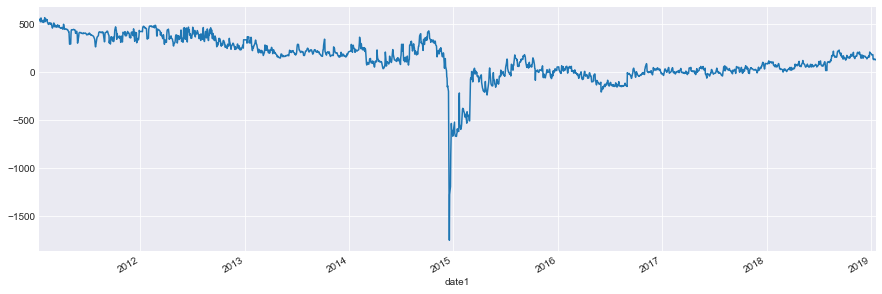

In [7]:
plt.rcParams['figure.figsize'] = (15, 5) #plot size
candidate_series.plot(grid=True) #series plot

Some outliers are present because of regulatory measures implemented during the Black Tuesday on 16th December 2014

Since actions of the Central Bank of Russia do not seem to be an intrinsic property of these time series, we can remove these outliers.

In [8]:
df1 = df0.mask((df0 - df0.mean()).abs() > 3 * df0.std()).dropna()
df1.describe()

,t,ABSPR,1YLSPR,1T3YSPR,3T5YSPR,BBBABSPR,BBB1T3SPR,BBB3T5SPR,CDS1Y,CDS2Y,CDS3Y,CDS4Y,CDS5Y,CLI SADJ,CPI
count,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000
mean,1017.094671,162.384377,122.041386,151.513709,161.231764,127.979307,114.778065,147.852561,94.489224,122.926922,150.363994,175.418065,199.761619,100.463311,100.457346
std,588.868514,136.322510,98.629519,120.046547,171.203918,141.741321,139.316766,159.496300,78.705158,77.035318,74.060219,70.781496,67.631125,1.458056,0.305577
min,16.000000,-133.000000,-111.000000,-119.000000,-238.000000,-208.000000,-198.000000,-263.000000,13.210000,35.810000,54.400000,78.050000,101.950000,97.610000,99.460000
25%,499.000000,47.000000,38.000000,58.000000,22.000000,7.000000,-2.000000,18.000000,40.090000,68.860000,95.940000,121.120000,145.950000,99.540000,100.290000
50%,1046.000000,152.000000,118.000000,136.000000,152.000000,123.000000,111.000000,134.000000,68.230000,98.740000,126.320000,148.500000,176.480000,100.390000,100.440000
75%,1535.000000,271.000000,201.000000,256.000000,303.000000,229.000000,221.000000,259.000000,114.970000,154.050000,185.580000,214.650000,239.080000,101.010000,100.620000
max,2022.000000,513.000000,386.000000,476.000000,569.000000,503.000000,487.000000,537.000000,432.990000,442.230000,447.940000,453.100000,457.740000,103.700000,101.280000


In [9]:
df1['CDS1Y'].head()

date1
2011-02-01    51.25
2011-02-02    51.75
2011-02-03    53.25
2011-02-04    49.75
2011-02-07    47.50
Name: CDS1Y, dtype: float64

In [10]:
#List of series: ABSPR, 1YLSPR, 1T3YSPR, 3T5YSPR, BBBABSPR, BBB1T3SPR, BBB3T5SPR
candidate_series = df1['ABSPR'] #set the one you need

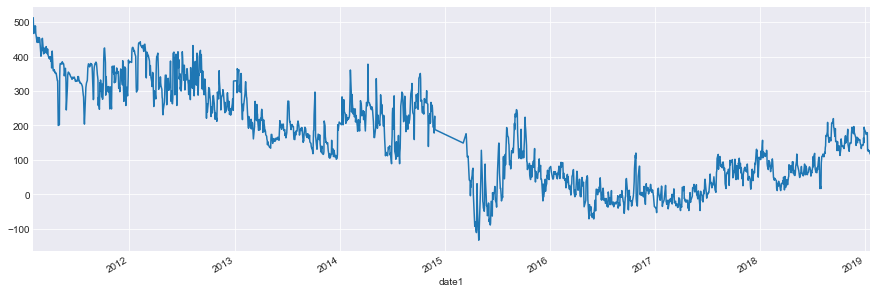

In [11]:
plt.rcParams['figure.figsize'] = (15, 5) #plot size
candidate_series.plot(grid=True) #series plot

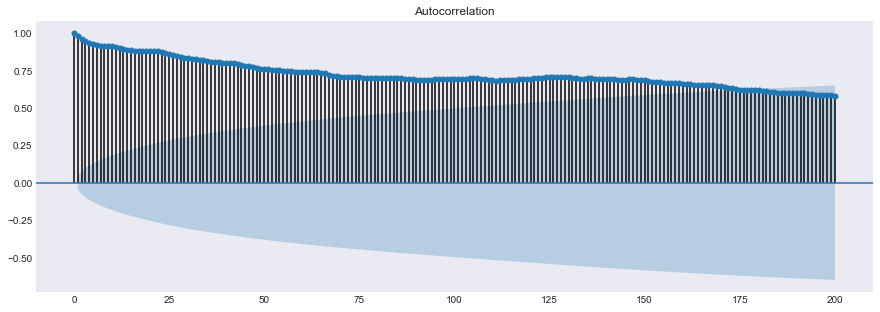

In [12]:
plot_acf(candidate_series, lags = 200) #ACF for reasonable number of lags.
plt.show() #Blue space denotes 95% confidence interval for H0: no autocorrelation is present.

It seems strong positive autocorrelation is present

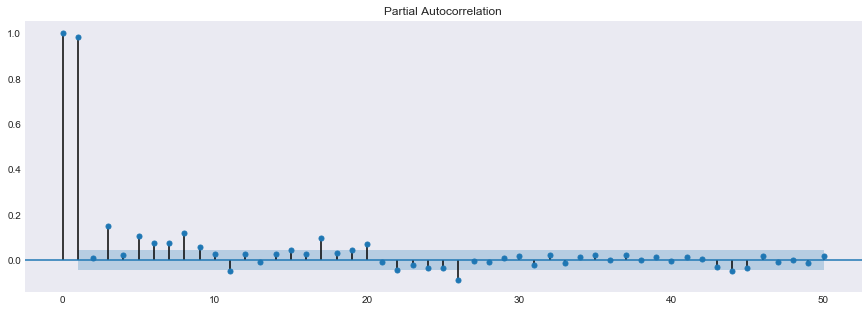

In [13]:
plot_pacf(candidate_series, lags = 50) #PACF plot for reasonable number of lags.
plt.show()

PACF plot indicates strong positive autocorrelation for the first lag and negative for the second

In [14]:
def adfuller_series(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [15]:
adfuller_series(candidate_series)

ADF Statistic: -2.329872
p-value: 0.162515


The ACF for differenced series looks like:

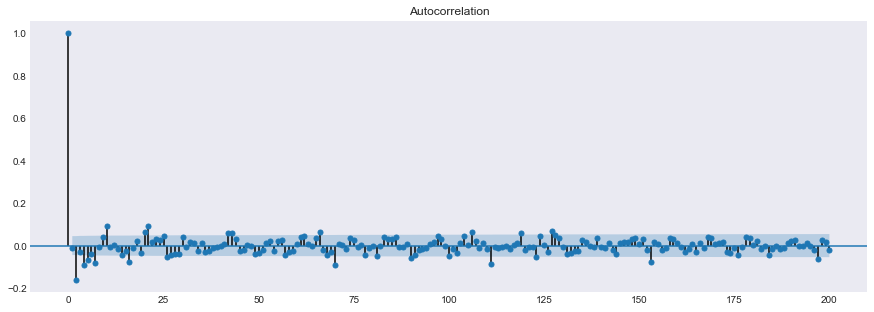

In [16]:
plot_acf(candidate_series.diff().dropna(), lags = 200) #ACF for reasonable number of lags.
plt.show() #Blue space denotes 95% confidence interval for H0: no autocorrelation is present.

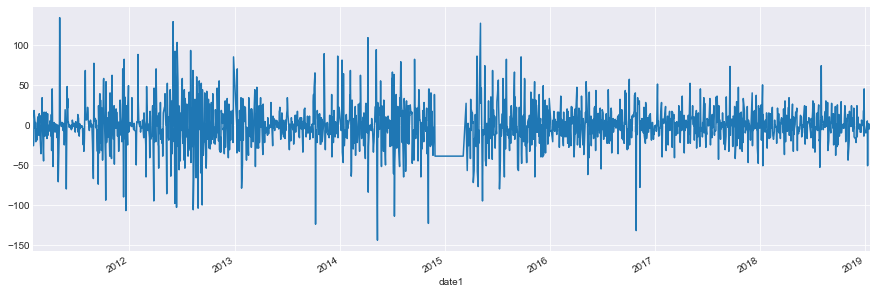

In [17]:
plt.rcParams['figure.figsize'] = (15, 5) #plot size
candidate_series.diff().plot(grid=True) #series plot

# Data preparation

In this section we will choose the sizes of training set and test set.<br>
Training set is used for fitting the model.<br>
Test set will be used for out-of-sample forecast evaluation.<br>

In [17]:
training_set_size = 0.7

In [18]:
print ("Training set uses " + str(int(training_set_size*100)) + "% of the data")
print ("Test set uses " + str(int((1-training_set_size)*100)) + "% of the data")

Training set uses 70% of the data
Test set uses 30% of the data


Here one can set a suitable p-value for the tests. It is 0.05 by default.

In [19]:
p_value_critical = 0.05

The next cells output ADF-test results for each series in the dataset.

In [20]:
column_range_bonds = range(1,8)

In [21]:
def adfuller_test_bonds(X, p_value):
    series = []
    p_values = []
    training_size = int(len(X.index) * training_set_size)
    train = X[0:training_size]
    print(train.describe())
    for column in column_range_bonds:
        result = adfuller(train.iloc[:, column])
        print(train.columns.values[column])
        print('ADF Statistic: %f' % result[0])
        series.append(column)
        print('p-value: %f' % result[1])
        p_values.append(result[1])
        if result[1]<=p_value:
            print('Stationary, reject H0')
        else:
            print('Non-stationary, H0 is not rejected')
        print('\n')
    adfuller_df = pd.DataFrame(
            {'Series name': series,
             'P-values': p_values})
    return adfuller_df

In [22]:
adfuller_bonds_df = adfuller_test_bonds(df1, p_value = p_value_critical)
adfuller_bonds_df

                 t        ABSPR       1YLSPR      1T3YSPR      3T5YSPR  \
count  1353.000000  1353.000000  1353.000000  1353.000000  1353.000000   
mean    712.014782   205.988174   156.712491   189.469327   206.305987   
std     415.951468   136.162103    90.357186   118.870227   182.613091   
min      16.000000  -133.000000   -97.000000  -119.000000  -238.000000   
25%     354.000000   106.000000    96.000000    92.000000    61.000000   
50%     692.000000   219.000000   164.000000   212.000000   221.000000   
75%    1100.000000   315.000000   227.000000   280.000000   361.000000   
max    1438.000000   513.000000   386.000000   476.000000   569.000000   

          BBBABSPR    BBB1T3SPR    BBB3T5SPR        CDS1Y        CDS2Y  \
count  1353.000000  1353.000000  1353.000000  1353.000000  1353.000000   
mean    167.609756   157.590540   190.931264   113.965196   145.887051   
std     147.851357   140.055619   168.368513    84.929426    80.290464   
min    -208.000000  -198.000000  -263

,Series name,P-values
0,1,0.533492
1,2,0.089434
2,3,0.370667
3,4,0.343517
4,5,0.444301
5,6,0.444801
6,7,0.455128


It seems that for all series hypothesis of presence of a unit root is not rejected

# Conditional mean

## ARIMA in-sample fitting

Fitting the model on the test set using BIC

Choose the series:

In [23]:
#List of series: ABSPR, 1YLSPR, 1T3YSPR, 3T5YSPR, BBBABSPR, BBB1T3SPR, BBB3T5SPR
candidate_series = df1['1YLSPR'] #set the one you need

Set hyperparameters for grid search:

In [24]:
p_values = range(0, 5) # Note: range(start, end) does not include end point
d_values = range(0, 2)
q_values = range(0, 4)

In [25]:
def evaluate_arima_models_in_sample(dataset, p_values, d_values, q_values):
    dataset = dataset.values.astype('float32')
    best_score, best_cfg = float("inf"), None
    training_size = int(len(dataset) * training_set_size)
    train = dataset[0:training_size]
    for d in d_values:
        result = adfuller(train)
        print(result[1])
        if result[1] < p_value_critical:
            d = 0
        else:
            d = d
        for p in p_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(train, order = order)
                    model_fit = model.fit(disp=0)
                    bic = model_fit.bic
                    if bic < best_score:
                        best_score, best_cfg = bic, order
                    print('ARIMA%s BIC=%.3f' % (order, bic))
                except:
                    continue
    print('Best ARIMA%s BIC=%.3f' % (best_cfg, best_score))

Run the search function

In [26]:
warnings.filterwarnings("ignore")
evaluate_arima_models_in_sample(candidate_series, p_values, d_values, q_values)

0.08943357345145003
ARIMA(0, 0, 0) BIC=16040.271
ARIMA(0, 0, 1) BIC=14871.541
ARIMA(0, 0, 2) BIC=14329.459
ARIMA(1, 0, 0) BIC=13478.563
ARIMA(1, 0, 1) BIC=13478.455
ARIMA(1, 0, 2) BIC=13456.501
ARIMA(1, 0, 3) BIC=13446.571
ARIMA(2, 0, 0) BIC=13480.398
ARIMA(2, 0, 1) BIC=13422.019
ARIMA(2, 0, 2) BIC=13424.194
ARIMA(2, 0, 3) BIC=13431.394
ARIMA(3, 0, 0) BIC=13468.308
ARIMA(3, 0, 1) BIC=13424.234
ARIMA(4, 0, 0) BIC=13469.416
ARIMA(4, 0, 1) BIC=13431.440
0.08943357345145003
ARIMA(0, 1, 0) BIC=13513.077
ARIMA(0, 1, 1) BIC=13500.874
ARIMA(0, 1, 2) BIC=13459.254
ARIMA(0, 1, 3) BIC=13439.414
ARIMA(1, 1, 0) BIC=13506.869
ARIMA(1, 1, 1) BIC=13408.872
ARIMA(1, 1, 2) BIC=13411.339
ARIMA(1, 1, 3) BIC=13418.523
ARIMA(2, 1, 0) BIC=13484.093
ARIMA(2, 1, 1) BIC=13411.405
ARIMA(2, 1, 2) BIC=13418.446
ARIMA(2, 1, 3) BIC=13425.618
ARIMA(3, 1, 0) BIC=13480.122
ARIMA(3, 1, 1) BIC=13418.596
ARIMA(3, 1, 2) BIC=13425.595
ARIMA(3, 1, 3) BIC=13423.217
ARIMA(4, 1, 0) BIC=13472.711
ARIMA(4, 1, 1) BIC=13423.740
ARI

Now I implement iteration across columns to find the most fitting ARIMA order for in-sample estimation

In [27]:
def best_arimas_in_sample(X, p_values, d_values, q_values):
    col_list = [0]*7
    p_list = [0]*7
    d_list = [0]*7
    q_list = [0]*7
    for column in range(1,8):
        dataset = X.iloc[:,column]
        best_score, best_cfg = float("inf"), None
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        for d in d_values:
            result = adfuller(train)
            if result[1] < p_value_critical:
                d = 0
            else:
                d = d
            for p in p_values:
                for q in q_values:
                    order = (p,d,q)
                    try:
                        model = ARIMA(train, order = order)
                        model_fit = model.fit(disp=0)
                        bic = model_fit.bic
                        if bic < best_score:
                            best_score, best_cfg = bic, order
                            col_list[column-1] = column
                            p_list[column-1] = p
                            d_list[column-1] = d
                            q_list[column-1] = q
                        #print('ARIMA%s BIC=%.3f' % (order, bic))
                    except:
                        continue   
        print(df1.columns.values[column])
        print('Best ARIMA%s BIC=%.3f' % (best_cfg, best_score))
        print('\n')
        best_arimas_df = pd.DataFrame(
            {'Series': col_list,
             'p': p_list,
             'd': d_list,
             'q': q_list
            })
    return best_arimas_df

In [28]:
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

In [29]:
warnings.filterwarnings("ignore")
df_best_arimas = best_arimas_in_sample(df1, p_values, d_values, q_values)

ABSPR
Best ARIMA(2, 1, 2) BIC=12851.497


1YLSPR
Best ARIMA(1, 1, 1) BIC=13408.872


1T3YSPR
Best ARIMA(1, 1, 2) BIC=12919.630


3T5YSPR
Best ARIMA(1, 1, 2) BIC=13023.142


BBBABSPR
Best ARIMA(1, 1, 2) BIC=12871.629


BBB1T3SPR
Best ARIMA(1, 1, 2) BIC=12909.838


BBB3T5SPR
Best ARIMA(1, 1, 2) BIC=12987.807




The function outputs a dataframe with the fittest ARIMA parameters

In [30]:
df_best_arimas

,Series,p,d,q
0,1,2,1,2
1,2,1,1,1
2,3,1,1,2
3,4,1,1,2
4,5,1,1,2
5,6,1,1,2
6,7,1,1,2


One can display summary statistics for ARIMA fitting:

In [31]:
#List of series: ABSPR, 1YLSPR, 1T3YSPR, 3T5YSPR, BBBABSPR, BBB1T3SPR, BBB3T5SPR
candidate_series = df1['1YLSPR'] #set the one you need

                             ARIMA Model Results                              
Dep. Variable:               D.1YLSPR   No. Observations:                 1352
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6690.017
Method:                       css-mle   S.D. of innovations             34.095
Date:                Mon, 03 Jun 2019   AIC                          13388.034
Time:                        00:02:12   BIC                          13408.872
Sample:                             1   HQIC                         13395.837
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1250      0.278     -0.450      0.653      -0.669       0.419
ar.L1.D.1YLSPR     0.6858      0.031     22.051      0.000       0.625       0.747
ma.L1.D.1YLSPR    -0.9065      0.017

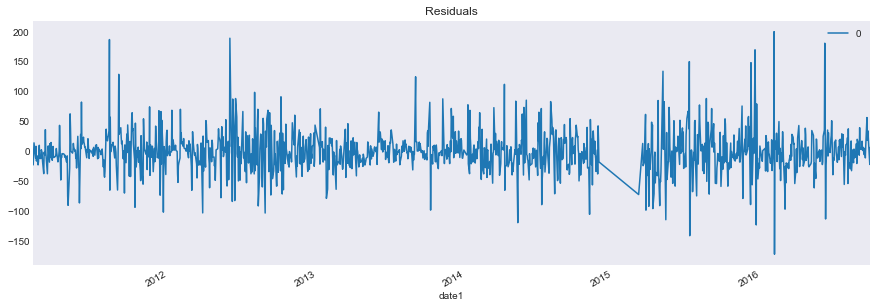

                 0
count  1352.000000
mean     -0.050306
std      34.108369
min    -171.954916
25%     -17.257040
50%      -0.471465
75%      15.402635
max     199.455152


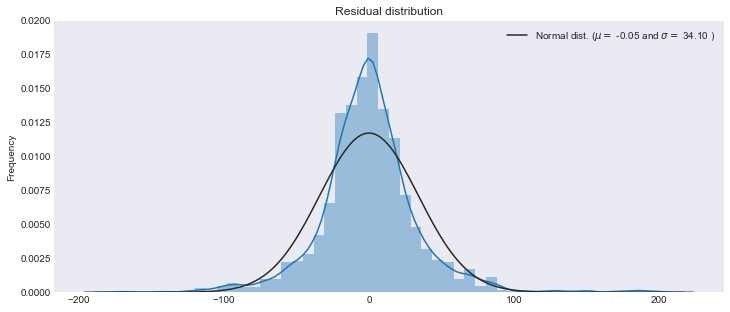

In [32]:
dataset = candidate_series
training_size = int(len(dataset) * training_set_size)
train = dataset[0:training_size]
test = dataset[training_size:]

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot(title="Residuals")
plt.show()
fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) 

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

print(residuals.describe())

It seems the residuals are centered near 0, have little to no skewness, but do have excess kurtosis.

In [33]:
df_best_arimas

,Series,p,d,q
0,1,2,1,2
1,2,1,1,1
2,3,1,1,2
3,4,1,1,2
4,5,1,1,2
5,6,1,1,2
6,7,1,1,2


In [34]:
def residual_normality_check(X):
    for column in range(1,8):
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        p = df_best_arimas.iloc[column-1, 1]
        d = df_best_arimas.iloc[column-1, 2]
        q = df_best_arimas.iloc[column-1, 3]
        model = ARIMA(train, order=(p,d,q))
        model_fit = model.fit(disp=0)
        residuals = DataFrame(model_fit.resid)
        print(df1.columns.values[column])
        print(p,d,q)
        result = adfuller(model_fit.resid)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        if result[1]<=p_value_critical:
            print('Stationary, reject H0')
        else:
            print('Non-stationary, H0 is not rejected')
        print('\n')#end
        plt.plot(residuals)
        
        fig = plt.figure(figsize=(12,5))
        ax0 = fig.add_subplot(111)

        sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

        # Get the fitted parameters used by the function
        (mu, sigma) = stats.norm.fit(residuals)

        #Now plot the distribution using 
        plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
        plt.ylabel('Frequency')
        plt.title('Residual distribution')


        # ACF and PACF
        fig = plt.figure(figsize=(12,5))
        ax1 = fig.add_subplot(211)
        fig = sm.graphics.tsa.plot_acf(residuals, lags=20, ax=ax1)
        plt.show()

ABSPR
2 1 2
ADF Statistic: -5.490307
p-value: 0.000002
Stationary, reject H0




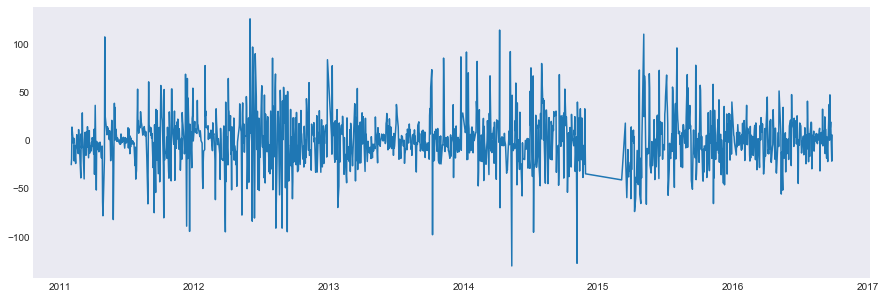

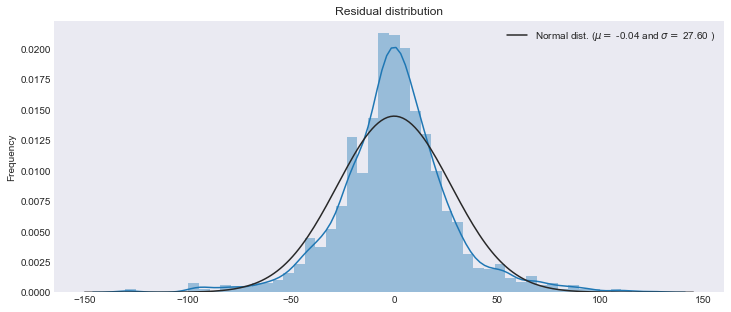

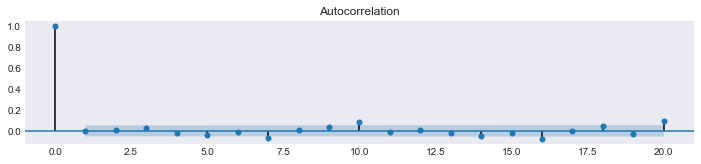

1YLSPR
1 1 1
ADF Statistic: -5.840786
p-value: 0.000000
Stationary, reject H0




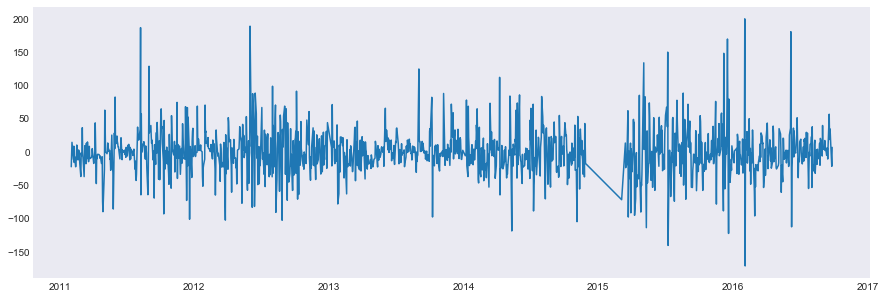

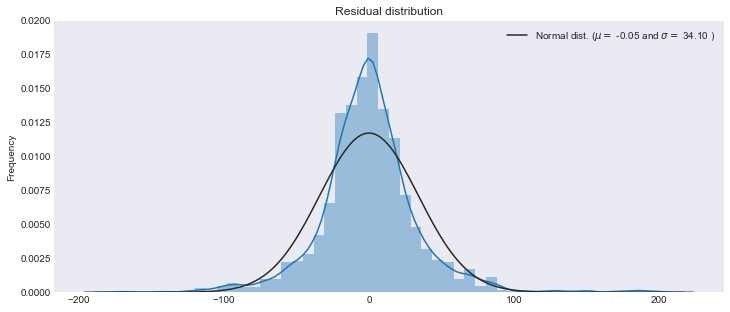

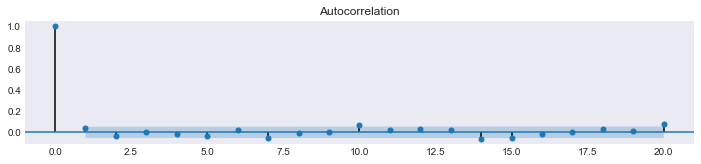

1T3YSPR
1 1 2
ADF Statistic: -5.840614
p-value: 0.000000
Stationary, reject H0




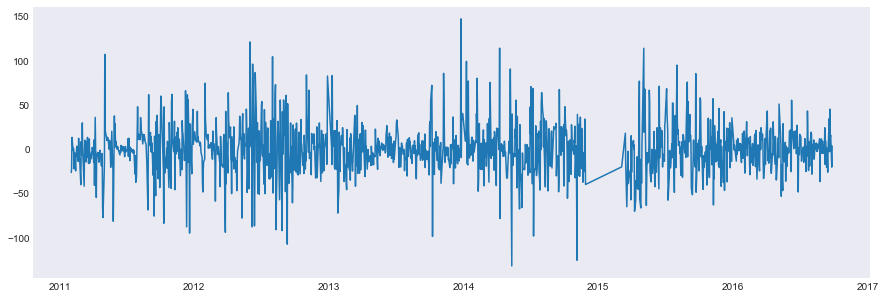

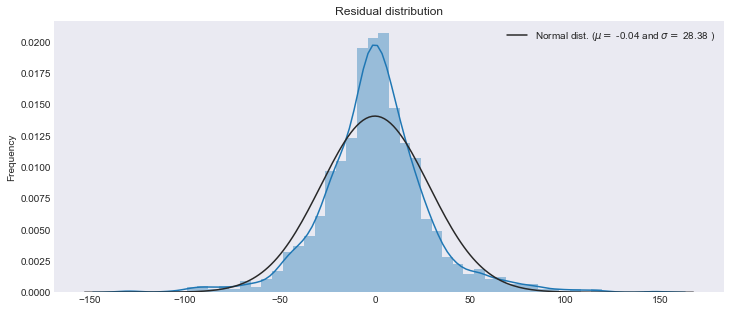

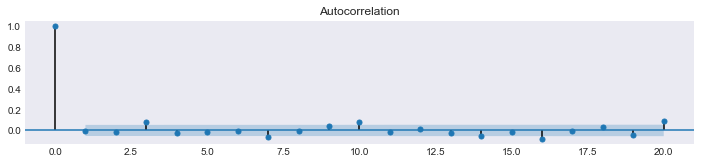

3T5YSPR
1 1 2
ADF Statistic: -4.636965
p-value: 0.000110
Stationary, reject H0




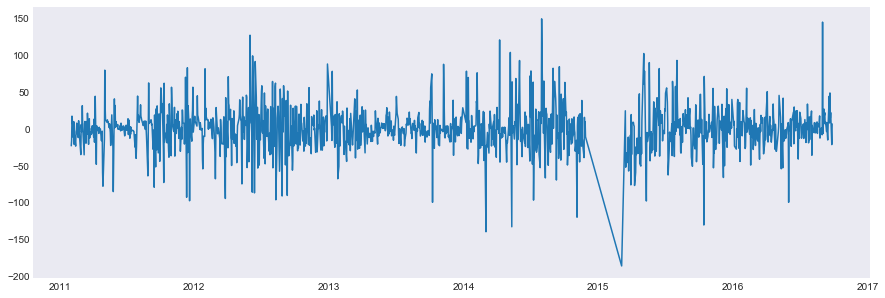

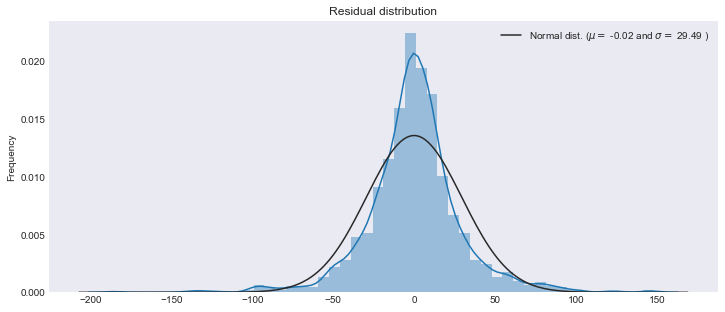

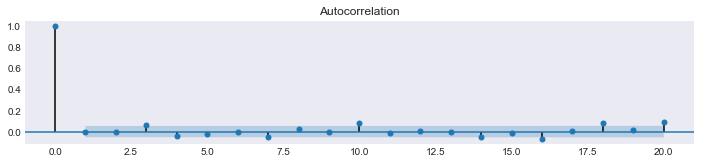

BBBABSPR
1 1 2
ADF Statistic: -5.301517
p-value: 0.000005
Stationary, reject H0




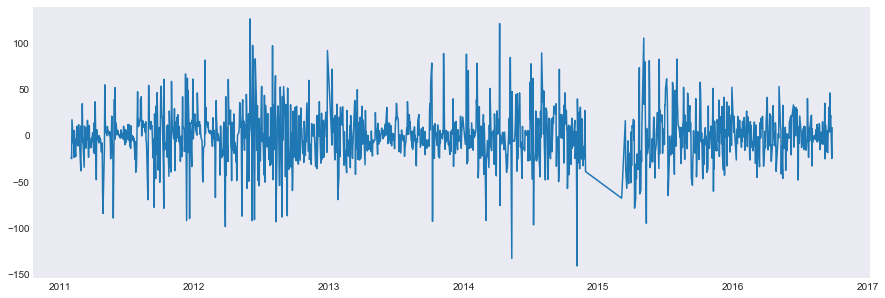

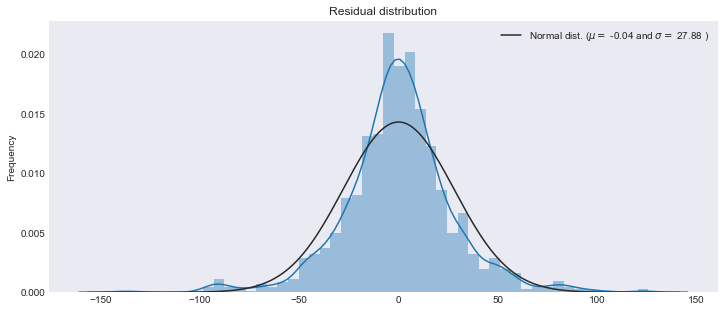

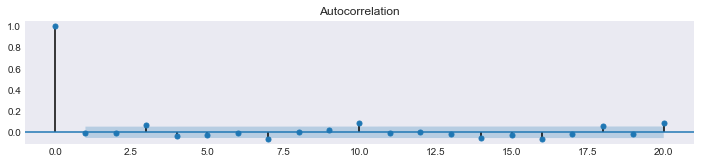

BBB1T3SPR
1 1 2
ADF Statistic: -5.479815
p-value: 0.000002
Stationary, reject H0




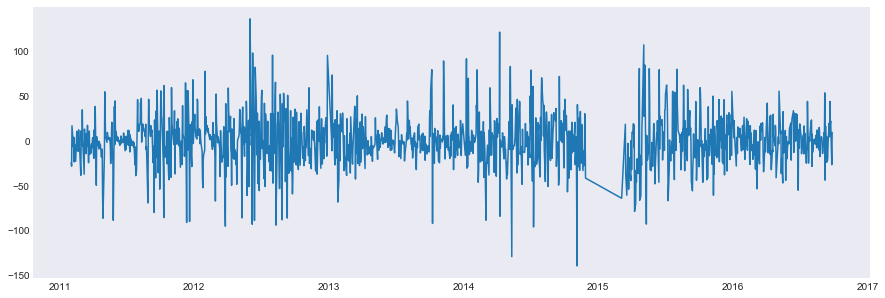

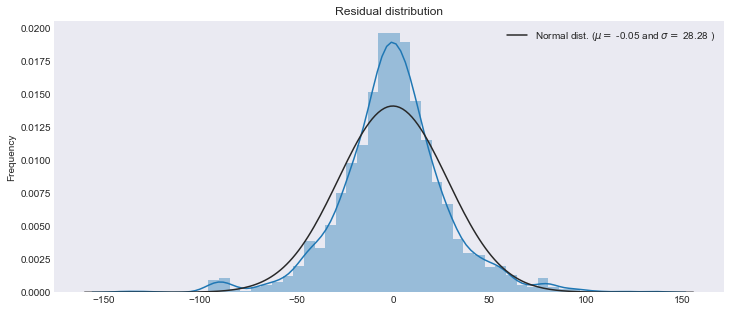

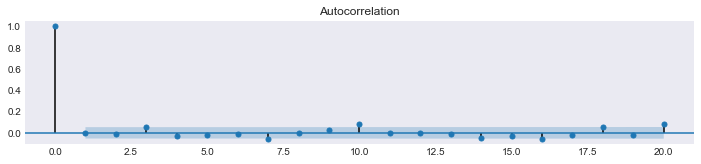

BBB3T5SPR
1 1 2
ADF Statistic: -4.956763
p-value: 0.000027
Stationary, reject H0




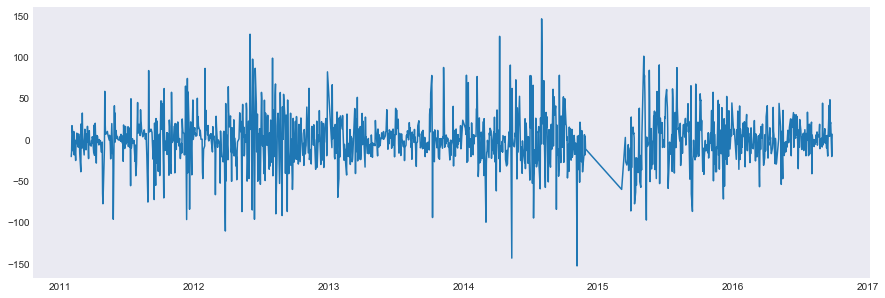

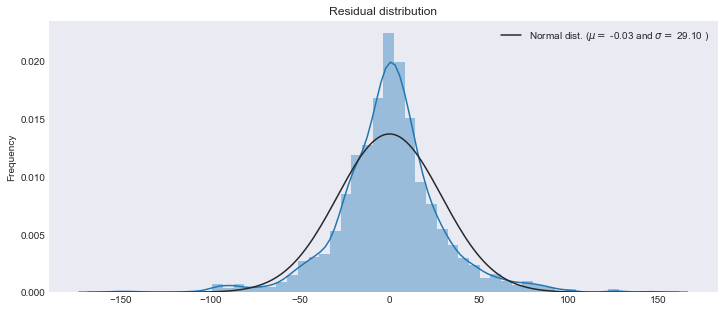

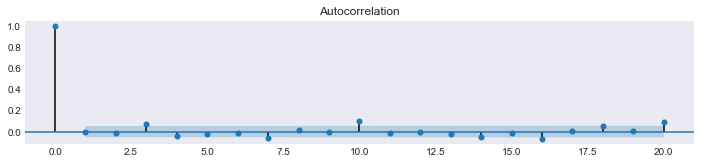

In [35]:
residual_normality_check(df1)

It seems the residuals are stationary, but not normal. They have excess kurtosis and fat tails. Possible heteroskedasticity may be present.

## ARIMAX fitting

I will use ARIMA with exogenous factors: CPI and CLI

In [36]:
df1.head()

,t,ABSPR,1YLSPR,1T3YSPR,3T5YSPR,BBBABSPR,BBB1T3SPR,BBB3T5SPR,CDS1Y,CDS2Y,CDS3Y,CDS4Y,CDS5Y,CLI SADJ,CPI
date1,,,,,,,,,,,,,,,
2011-02-01,16,513.0,264.0,476.0,569.0,503.0,487.0,537.0,51.25,87.75,114.25,127.5,143.00,103.37,100.78
2011-02-02,17,487.0,241.0,449.0,545.0,479.0,462.0,516.0,51.75,88.75,115.25,128.5,144.67,103.37,100.78
2011-02-03,18,467.0,238.0,426.0,528.0,453.0,433.0,501.0,53.25,92.75,119.25,131.5,147.33,103.37,100.78
2011-02-04,19,485.0,255.0,443.0,548.0,473.0,453.0,521.0,49.75,89.75,116.25,129.5,144.33,103.37,100.78
2011-02-07,20,489.0,248.0,447.0,552.0,478.0,457.0,528.0,47.50,85.00,111.50,125.0,140.83,103.37,100.78


Choose the series:

In [37]:
#List of series: ABSPR, 1YLSPR, 1T3YSPR, 3T5YSPR, BBBABSPR, BBB1T3SPR, BBB3T5SPR
candidate_series = df1['1YLSPR'] #set the one you need

Set hyperparameters for grid search:

In [38]:
p_values = range(0, 5) # Note: range(start, end) does not include end point
d_values = range(0, 2)
q_values = range(0, 4)

In [39]:
exogenous1 = df1.iloc[:, 13]
exogenous2 = df1.iloc[:, 14]
exog_df = pd.DataFrame(
            {'CLI': exogenous1,
             'CPI': exogenous2})
exog_df.iloc[:25,].head()

,CLI,CPI
date1,,
2011-02-01,103.37,100.78
2011-02-02,103.37,100.78
2011-02-03,103.37,100.78
2011-02-04,103.37,100.78
2011-02-07,103.37,100.78


In [40]:
def evaluate_arimax_models_in_sample(dataset, p_values, d_values, q_values, exog = exog_df):
    dataset = dataset.values.astype('float32')
    best_score, best_cfg = float("inf"), None
    training_size = int(len(dataset) * training_set_size)
    train = dataset[0:training_size]
    exog_df_tr = exog_df.iloc[ :training_size, ]
    for d in d_values:
        result = adfuller(train)
        if result[1] < p_value_critical:
            d = 0
        else:
             d = d
        for p in p_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(train, order = order, exog = exog_df_tr)
                    model_fit = model.fit(disp=0)
                    bic = model_fit.bic
                    if bic < best_score:
                        best_score, best_cfg = bic, order
                    print('ARIMAX%s BIC=%.3f' % (order, bic))
                except:
                    continue
    print('Best ARIMAX%s BIC=%.3f' % (best_cfg, best_score))

Run the search function

In [41]:
warnings.filterwarnings("ignore")
evaluate_arimax_models_in_sample(candidate_series, p_values, d_values, q_values)

ARIMAX(0, 0, 0) BIC=15635.381
ARIMAX(0, 0, 1) BIC=14585.841
ARIMAX(0, 0, 2) BIC=14138.805
ARIMAX(0, 0, 3) BIC=13921.926
ARIMAX(1, 0, 0) BIC=13487.091
ARIMAX(1, 0, 1) BIC=13488.978
ARIMAX(1, 0, 2) BIC=13470.580
ARIMAX(1, 0, 3) BIC=13459.501
ARIMAX(2, 0, 0) BIC=13490.294
ARIMAX(2, 0, 1) BIC=13435.511
ARIMAX(2, 0, 2) BIC=13438.356
ARIMAX(3, 0, 0) BIC=13480.499
ARIMAX(3, 0, 1) BIC=13437.441
ARIMAX(4, 0, 0) BIC=13482.502
ARIMAX(4, 0, 2) BIC=13451.037
ARIMAX(0, 1, 0) BIC=13526.482
ARIMAX(0, 1, 1) BIC=13514.039
ARIMAX(0, 1, 2) BIC=13471.001
ARIMAX(0, 1, 3) BIC=13448.528
ARIMAX(1, 1, 0) BIC=13520.148
ARIMAX(1, 1, 1) BIC=13414.387
ARIMAX(1, 1, 2) BIC=13416.911
ARIMAX(1, 1, 3) BIC=13424.048
ARIMAX(2, 1, 0) BIC=13497.066
ARIMAX(2, 1, 1) BIC=13416.938
ARIMAX(2, 1, 2) BIC=13423.964
ARIMAX(2, 1, 3) BIC=13431.141
ARIMAX(3, 1, 0) BIC=13492.811
ARIMAX(3, 1, 1) BIC=13424.125
ARIMAX(3, 1, 2) BIC=13431.116
ARIMAX(3, 1, 3) BIC=13428.718
ARIMAX(4, 1, 0) BIC=13484.873
ARIMAX(4, 1, 1) BIC=13429.320
ARIMAX(4, 

Now I implement iteration across columns to find the most fitting ARIMAX order for in-sample estimation

In [42]:
def best_arimax_in_sample(X, p_values, d_values, q_values, exog = exog_df):
    col_list = [0]*7
    p_list = [0]*7
    d_list = [0]*7
    q_list = [0]*7
    for column in range(1,8):
        dataset = X.iloc[:,column]
        best_score, best_cfg = float("inf"), None
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        exog_df_tr = exog_df.iloc[ :training_size, ]
        for d in d_values:
            result = adfuller(train)
            if result[1] < p_value_critical:
                d = 0
            else:
                d = d
            for p in p_values:
                for q in q_values:
                    order = (p,d,q)
                    try:
                        model = ARIMA(train, order = order, exog = exog_df_tr)
                        model_fit = model.fit(disp=0)
                        bic = model_fit.bic
                        if bic < best_score:
                            best_score, best_cfg = bic, order
                            col_list[column-1] = column
                            p_list[column-1] = p
                            d_list[column-1] = d
                            q_list[column-1] = q
                        #print('ARIMA%s BIC=%.3f' % (order, bic))
                    except:
                        continue   
        print(df1.columns.values[column])
        print('Best ARIMAX%s BIC=%.3f' % (best_cfg, best_score))
        print('\n')
        best_arimax_df = pd.DataFrame(
            {'Series': col_list,
             'p': p_list,
             'd': d_list,
             'q': q_list
            })
    return best_arimax_df

In [43]:
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

In [44]:
warnings.filterwarnings("ignore")
df_best_arimax = best_arimax_in_sample(df1, p_values, d_values, q_values)

ABSPR
Best ARIMAX(2, 1, 2) BIC=12860.565


1YLSPR
Best ARIMAX(1, 1, 1) BIC=13414.387


1T3YSPR
Best ARIMAX(1, 1, 2) BIC=12929.528


3T5YSPR
Best ARIMAX(1, 1, 2) BIC=13027.792


BBBABSPR
Best ARIMAX(1, 1, 2) BIC=12878.186


BBB1T3SPR
Best ARIMAX(1, 1, 2) BIC=12917.110


BBB3T5SPR
Best ARIMAX(1, 1, 2) BIC=12993.812




The function outputs a dataframe with the fittest ARIMAX parameters

In [45]:
df_best_arimax

,Series,p,d,q
0,1,2,1,2
1,2,1,1,1
2,3,1,1,2
3,4,1,1,2
4,5,1,1,2
5,6,1,1,2
6,7,1,1,2


In [46]:
df_best_arimas

,Series,p,d,q
0,1,2,1,2
1,2,1,1,1
2,3,1,1,2
3,4,1,1,2
4,5,1,1,2
5,6,1,1,2
6,7,1,1,2


One can display summary statistics for ARIMAX fitting:

In [47]:
#List of series: ABSPR, 1YLSPR, 1T3YSPR, 3T5YSPR, BBBABSPR, BBB1T3SPR, BBB3T5SPR
candidate_series = df1['BBB3T5SPR'] #set the one you need

In [48]:
def arimax_summary(X):
    dataset = X
    training_size = int(len(dataset) * training_set_size)
    train = dataset[0:training_size]
    test = dataset[training_size:]
    exog_df_tr = exog_df.iloc[ :training_size, ]

    model = ARIMA(train, order=(1,1,2), exog = exog_df_tr)
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

    # plot residual errors
    residuals = DataFrame(model_fit.resid)
    residuals.plot(title="Residuals")
    plt.show()
    fig = plt.figure(figsize=(12,5))
    ax0 = fig.add_subplot(111)

    sns.distplot(residuals ,fit = stats.norm, ax = ax0) 

    # Get the fitted parameters used by the function
    (mu, sigma) = stats.norm.fit(residuals)

    #Now plot the distribution using 
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')

    print(residuals.describe())

In [ ]:
arimax_summary(candidate_series)

Coefficient corresponding to CPI is significant, so ARIMAX is likely an improvement in goodness-of-fit terms, but the residuals still have high kurtosis

In [50]:
residuals.head()

,0
date1,
2011-02-02,-22.875033
2011-02-03,-6.176676
2011-02-04,13.859993
2011-02-07,-6.690357
2011-02-08,-11.983019


In [51]:
print('P-value: %f' % normaltest(residuals)[1])

P-value: 0.000000


In [52]:
def residual_normality_check_arimax(X):
    for column in range(1,8):
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        exog_df_tr = exog_df.iloc[ :training_size, ]
        p = df_best_arimax.iloc[column-1, 1]
        d = df_best_arimax.iloc[column-1, 2]
        q = df_best_arimax.iloc[column-1, 3]
        model = ARIMA(train, order=(p,d,q), exog = exog_df_tr)
        model_fit = model.fit(disp=0)
        print(df1.columns.values[column])
        print(p,d,q)
        residuals = DataFrame(model_fit.resid)#begin
        result = adfuller(model_fit.resid)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        if result[1]<=p_value_critical:
            print('Stationary, reject H0')
        else:
            print('Non-stationary, H0 is not rejected')
        print('\n')#end
        fig = plt.figure(figsize=(12,5))
        ax0 = fig.add_subplot(111)

        sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

        # Get the fitted parameters used by the function
        (mu, sigma) = stats.norm.fit(residuals)

        #Now plot the distribution using 
        plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
        plt.ylabel('Frequency')
        plt.title('Residual distribution')


        # ACF and PACF
        fig = plt.figure(figsize=(12,5))
        ax1 = fig.add_subplot(211)
        fig = sm.graphics.tsa.plot_acf(residuals, lags=20, ax=ax1)
        plt.show()

In [ ]:
residual_normality_check_arimax(df1)

Residuals normality check has exhibited roughly the same results as for ARIMA models without exogenous variables. <br><br>
This implies that there may be heteroskedasticity, omitted variables or significant non-linear dependencies present.

# Conditional variance

## Residual autocorrelation

Since inclusion of macroeconomic exogenous variables was not sufficient to make the residuals normal, it is suspected that the process is subjected to non-constant conditional variance. <br><br>

That is why I will test the residuals for the presence of ARCH effects and develop suitable ARCH/GARCH model for conditional variance.

In [54]:
def ljung_box_test(x, lags):
    q_test = sm.tsa.stattools.acf(x, qstat=True, nlags = lags)
    q_test_df = pd.DataFrame(q_test)
    return DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})

In [55]:
df_best_arimas

,Series,p,d,q
0,1,2,1,2
1,2,1,1,1
2,3,1,1,2
3,4,1,1,2
4,5,1,1,2
5,6,1,1,2
6,7,1,1,2


In [56]:
df_best_arimax

,Series,p,d,q
0,1,2,1,2
1,2,1,1,1
2,3,1,1,2
3,4,1,1,2
4,5,1,1,2
5,6,1,1,2
6,7,1,1,2


Examining the residuals to determine if ARCH effects are present, using Ljung-Box test:

In [57]:
def arch_check_arimas(X, lags):
    col_list = [0]*7
    ljung_pval_list = [0]*7
    for column in range(1,8):
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        exog_df_tr = exog_df.iloc[ :training_size, ]
        p = df_best_arimax.iloc[column-1, 1]
        d = df_best_arimax.iloc[column-1, 2]
        q = df_best_arimax.iloc[column-1, 3]
        model = ARIMA(train, order=(p,d,q))
        model_fit = model.fit(disp=0)
        residuals = model_fit.resid
        #print(df1.columns.values[column]) #debug
        #print(p,d,q)
        df_ljung = ljung_box_test(residuals, lags)
        #print(df_ljung.iloc[lags-1,1])
        #print('\n')
        col_list[column-1] = column
        ljung_pval_list[column-1] = df_ljung.iloc[lags-1,1]
    ljung_pval_df_arimas = pd.DataFrame({'Series resids': col_list,'p_values': ljung_pval_list})
    return ljung_pval_df_arimas
    

def arch_check_arimax(X, lags):
    col_list = [0]*7
    ljung_pval_list = [0]*7
    for column in range(1,8):
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        exog_df_tr = exog_df.iloc[ :training_size, ]
        p = df_best_arimax.iloc[column-1, 1]
        d = df_best_arimax.iloc[column-1, 2]
        q = df_best_arimax.iloc[column-1, 3]
        model = ARIMA(train, order=(p,d,q), exog = exog_df_tr)
        model_fit = model.fit(disp=0)
        residuals = model_fit.resid
        #print(df1.columns.values[column]) #debug
        #print(p,d,q)
        df_ljung = ljung_box_test(residuals, lags)
        #print(df_ljung.iloc[lags-1,1])
        #print('\n')
        col_list[column-1] = column
        ljung_pval_list[column-1] = df_ljung.iloc[lags-1,1]
    ljung_pval_df_arimax = pd.DataFrame({'Series resids': col_list,'p_values': ljung_pval_list})
    return ljung_pval_df_arimax

In [58]:
ljung_pval_df_arimas = arch_check_arimas(df1, 10)
ljung_pval_df_arimas

,Series resids,p_values
0,1,0.016557
1,2,0.071738
2,3,0.002340
3,4,0.009501
4,5,0.007284
5,6,0.020180
6,7,0.001536


In [59]:
ljung_pval_df_arimax = arch_check_arimax(df1, 10)
ljung_pval_df_arimax

,Series resids,p_values
0,1,0.017405
1,2,0.075308
2,3,0.002482
3,4,0.010706
4,5,0.007911
5,6,0.021433
6,7,0.001733


It seems that for significance level of 0.05 only the spreads of bonds with 1-year duration do not show significant ARCH effects in residuals.<br>

## ARCH/GARCH fitting

As before, one may fit any GARCH model for chosen series

In [60]:
#List of series: ABSPR, 1YLSPR, 1T3YSPR, 3T5YSPR, BBBABSPR, BBB1T3SPR, BBB3T5SPR
candidate_series = df1['ABSPR'] #set the one you need

In [61]:
dataset = candidate_series.values.astype('float32')
train = dataset[0:training_size]
exog_df_tr = exog_df.iloc[ :training_size, ]
model = ARIMA(train, order=(1,1,2), exog = exog_df_tr)
residuals_g = model_fit.resid

garch11 = arch_model(residuals_g, p=1, q=1, mean='Zero')
res = garch11.fit(update_freq=10)
print(res.bic)
print(res.summary())

Iteration:     10,   Func. Count:     54,   Neg. LLF: 6614.699921595218
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6614.036955232245
            Iterations: 18
            Function evaluations: 97
            Gradient evaluations: 18
13249.7019312343
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -6614.04
Distribution:                  Normal   AIC:                           13234.1
Method:            Maximum Likelihood   BIC:                           13249.7
                                        No. Observations:                 1352
Date:                Mon, Jun 03 2019   Df Residuals:                     1349
Time:                        00:12:26   Df Model:                    

Best model search for chosen series, according to BIC and previous findings:

In [62]:
p_hyp_garch = range(0,5)
q_hyp_garch = range(0,5)

In [63]:
ljung_pval_df_arimax

,Series resids,p_values
0,1,0.017405
1,2,0.075308
2,3,0.002482
3,4,0.010706
4,5,0.007911
5,6,0.021433
6,7,0.001733


In [64]:
def evaluate_garch_models_arimax(X, p_hyp_garch = p_hyp_garch, q_hyp_garch = q_hyp_garch, exog = exog_df):
    dataset = X.values.astype('float32')
    best_score, best_cfg = float("inf"), None
    training_size = int(len(dataset) * training_set_size)
    train = dataset[0:training_size]
    exog_df_tr = exog_df.iloc[ :training_size, ]
    p = df_best_arimax.iloc[df1.columns.get_loc(X.name), 1]
    d = df_best_arimax.iloc[df1.columns.get_loc(X.name), 2]
    q = df_best_arimax.iloc[df1.columns.get_loc(X.name), 3]
    model = ARIMA(train, order=(p,d,q), exog = exog_df_tr)
    model_fit = model.fit(disp=0)
    residuals = model_fit.resid
    if ljung_pval_df_arimax.iloc[df1.columns.get_loc(X.name)-1,1]<p_value_critical:
        for p_garch in p_hyp_garch:
            for q_garch in q_hyp_garch:
                order = p_garch, q_garch
                #print(ljung_pval_df_arimax.iloc[df1.columns.get_loc(X.name)-1,1])
                try:
                    model = arch_model(residuals, p=p_garch, q=q_garch, mean='Zero')
                    model_fit = model.fit(disp=0)
                    #print(model_fit.summary())
                    bic = model_fit.bic
                    if bic < best_score:
                        best_score, best_cfg = bic, order
                    print('GARCH%s BIC=%.3f' % (order, bic))
                except:
                    continue
    else:
        print("No ARCH effects here")
    print('Best GARCH%s BIC=%.3f' % (best_cfg, best_score))

In [ ]:
evaluate_garch_models_arimax(candidate_series, p_hyp_garch = p_hyp_garch, q_hyp_garch = q_hyp_garch, exog = exog_df)

Now I will set hyperparameters and run the search for best-fitting conditional volatility model for each column

In [66]:
def best_garch_arimas(X, p_hyp_garch = p_hyp_garch, q_hyp_garch = q_hyp_garch):
    col_list = [0]*7
    p_list = [0]*7
    q_list = [0]*7
    for column in range(1,8):
        dataset = X.iloc[:,column]
        best_score, best_cfg = float("inf"), None
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        exog_df_tr = exog_df.iloc[ :training_size, ]
        p = df_best_arimax.iloc[column-1, 1]
        d = df_best_arimax.iloc[column-1, 2]
        q = df_best_arimax.iloc[column-1, 3]
        model = ARIMA(train, order=(p,d,q))
        model_fit = model.fit(disp=0)
        residuals = model_fit.resid
        for p_garch in p_hyp_garch:
            for q_garch in q_hyp_garch:
                order = p_garch, q_garch
                if ljung_pval_df_arimax.iloc[column-1,1]<p_value_critical:
                    try:
                        model = arch_model(residuals, p=p_garch, q=q_garch, mean='Zero')
                        model_fit = model.fit(disp=0)
                        bic = model_fit.bic
                        if bic < best_score:
                            best_score, best_cfg = bic, order
                            col_list[column-1] = column
                            p_list[column-1] = p_garch
                            q_list[column-1] = q_garch
                    except:
                        continue 
                else:
                    print("No ARCH effects here")
                    col_list[column-1] = column
        print(df1.columns.values[column])
        print('Best GARCH%s BIC=%.3f' % (best_cfg, best_score))
        print('\n')
        best_garch_arimas_df = pd.DataFrame(
            {'Series': col_list,
             'p': p_list,
             'q': q_list
            })
    return best_garch_arimas_df

def best_garch_arimax(X, p_hyp_garch = p_hyp_garch, q_hyp_garch = q_hyp_garch, exog = exog_df):
    col_list = [0]*7
    p_list = [0]*7
    q_list = [0]*7
    for column in range(1,8):
        dataset = X.iloc[:,column]
        best_score, best_cfg = float("inf"), None
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        exog_df_tr = exog_df.iloc[ :training_size, ]
        p = df_best_arimax.iloc[column-1, 1]
        d = df_best_arimax.iloc[column-1, 2]
        q = df_best_arimax.iloc[column-1, 3]
        model = ARIMA(train, order=(p,d,q), exog = exog_df_tr)
        model_fit = model.fit(disp=0)
        residuals = model_fit.resid
        for p_garch in p_hyp_garch:
            for q_garch in q_hyp_garch:
                order = p_garch, q_garch
                if ljung_pval_df_arimax.iloc[column-1,1]<p_value_critical:
                    try:
                        model = arch_model(residuals, p=p_garch, q=q_garch, mean='Zero')
                        model_fit = model.fit(disp=0)
                        bic = model_fit.bic
                        if bic < best_score:
                            best_score, best_cfg = bic, order
                            col_list[column-1] = column
                            p_list[column-1] = p_garch
                            q_list[column-1] = q_garch
                    except:
                        continue 
                else:
                    print("No ARCH effects here")
                    col_list[column-1] = column
        print(df1.columns.values[column])
        print('Best GARCH%s BIC=%.3f' % (best_cfg, best_score))
        print('\n')
        best_garch_arimax_df = pd.DataFrame(
            {'Series': col_list,
             'p': p_list,
             'q': q_list
            })
    return best_garch_arimax_df

In [ ]:
best_garch_arimas_df = best_garch_arimas(df1, p_hyp_garch, q_hyp_garch)

In [ ]:
best_garch_arimax_df = best_garch_arimax(df1, p_hyp_garch, q_hyp_garch)

In [69]:
best_garch_arimas_df

,Series,p,q
0,1,1,1
1,2,0,0
2,3,1,1
3,4,1,1
4,5,1,1
5,6,1,1
6,7,1,1


In [70]:
best_garch_arimax_df

,Series,p,q
0,1,1,1
1,2,0,0
2,3,1,1
3,4,1,1
4,5,1,1
5,6,1,2
6,7,1,1


In [71]:
def conditional_printer(X, df_best_arimas = df_best_arimas,
                        df_best_arimax = df_best_arimax,
                        best_garch_arimas_df = best_garch_arimas_df,
                        best_garch_arimax_df = best_garch_arimax_df):
    names = []
    p_ar = []
    d_ar = []
    q_ar = []
    p_arx = []
    d_arx = []
    q_arx = []
    p_gar = []
    q_gar = []
    p_garx = []
    q_garx = []
    
    for column in range(1,8):
        names.append(df1.columns.values[column])
        
        p_ar.append(df_best_arimas.iloc[column-1,1])
        d_ar.append(df_best_arimas.iloc[column-1,2])
        q_ar.append(df_best_arimas.iloc[column-1,3])
        
        p_arx.append(df_best_arimax.iloc[column-1,1])
        d_arx.append(df_best_arimax.iloc[column-1,2])
        q_arx.append(df_best_arimax.iloc[column-1,3])
        
        p_gar.append(best_garch_arimas_df.iloc[column-1,1])
        q_gar.append(best_garch_arimas_df.iloc[column-1,2])
        
        p_garx.append(best_garch_arimax_df.iloc[column-1,1])
        q_garx.append(best_garch_arimax_df.iloc[column-1,2])

    best_in_sample_df = pd.DataFrame(
            {'Series name': names,
             'p_ar': p_ar,
             'd_ar': d_ar,
             'q_ar': q_ar,
             'p_arx': q_arx,
             'd_arx': d_arx,
             'q_arx': q_arx,
             'p_gar': p_gar,
             'q_gar': q_gar,
             'p_garx': p_garx,
             'q_garx': q_garx
            })
    
    for column in range(1,8):
        print("Series " + str(best_in_sample_df.iloc[column-1,0]) + " is best described by ARIMA(" 
             + str(best_in_sample_df.iloc[column-1,1])
             + "," + str(best_in_sample_df.iloc[column-1,2]) + "," + str(best_in_sample_df.iloc[column-1,3]) + ")-GARCH("
             + str(best_in_sample_df.iloc[column-1,7]) + "," + str(best_in_sample_df.iloc[column-1,8]) + ")" + " or ARIMAX("
             + str(best_in_sample_df.iloc[column-1,4]) + "," + str(best_in_sample_df.iloc[column-1,5]) + "," 
             + str(best_in_sample_df.iloc[column-1,6]) 
             + ")-GARCH(" + str(best_in_sample_df.iloc[column-1,9]) + "," + str(best_in_sample_df.iloc[column-1,10]) + ")")
    return best_in_sample_df

In [72]:
conditional_df = conditional_printer(df1)

Series ABSPR is best described by ARIMA(2,1,2)-GARCH(1,1) or ARIMAX(2,1,2)-GARCH(1,1)
Series 1YLSPR is best described by ARIMA(1,1,1)-GARCH(0,0) or ARIMAX(1,1,1)-GARCH(0,0)
Series 1T3YSPR is best described by ARIMA(1,1,2)-GARCH(1,1) or ARIMAX(2,1,2)-GARCH(1,1)
Series 3T5YSPR is best described by ARIMA(1,1,2)-GARCH(1,1) or ARIMAX(2,1,2)-GARCH(1,1)
Series BBBABSPR is best described by ARIMA(1,1,2)-GARCH(1,1) or ARIMAX(2,1,2)-GARCH(1,1)
Series BBB1T3SPR is best described by ARIMA(1,1,2)-GARCH(1,1) or ARIMAX(2,1,2)-GARCH(1,2)
Series BBB3T5SPR is best described by ARIMA(1,1,2)-GARCH(1,1) or ARIMAX(2,1,2)-GARCH(1,1)


In [73]:
conditional_df

,Series name,p_ar,d_ar,q_ar,p_arx,d_arx,q_arx,p_gar,q_gar,p_garx,q_garx
0,ABSPR,2,1,2,2,1,2,1,1,1,1
1,1YLSPR,1,1,1,1,1,1,0,0,0,0
2,1T3YSPR,1,1,2,2,1,2,1,1,1,1
3,3T5YSPR,1,1,2,2,1,2,1,1,1,1
4,BBBABSPR,1,1,2,2,1,2,1,1,1,1
5,BBB1T3SPR,1,1,2,2,1,2,1,1,1,2
6,BBB3T5SPR,1,1,2,2,1,2,1,1,1,1


# CDS, Bonds and Granger causality

Testing whether CDS spreads Granger-cause bond spreads or vice versa.

One needs to insure series stationarity in order to perform this test to avoid spurious regressions.<br>
Let us look at the CDS series.

In [74]:
#List of CDS: CDS1Y, CDS2Y, CDS3Y, CDS4Y, CDS5Y
candidate_series = df1['CDS1Y'] #set the one you need

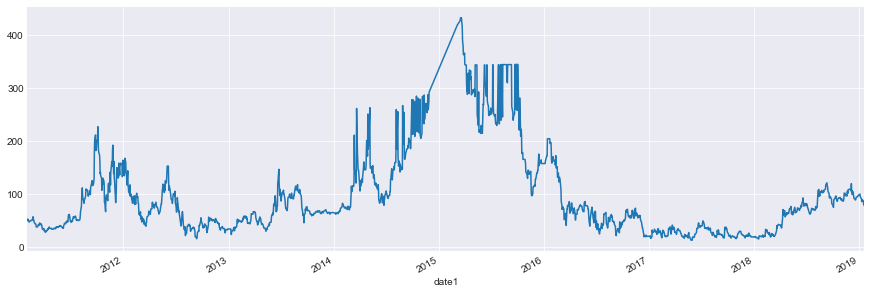

In [75]:
plt.rcParams['figure.figsize'] = (15, 5) #plot size
candidate_series.plot(grid=True) #series plot

In [76]:
adfuller_series(candidate_series)

ADF Statistic: -2.249418
p-value: 0.188801


Unit root is likely to be present, hence one should difference the series

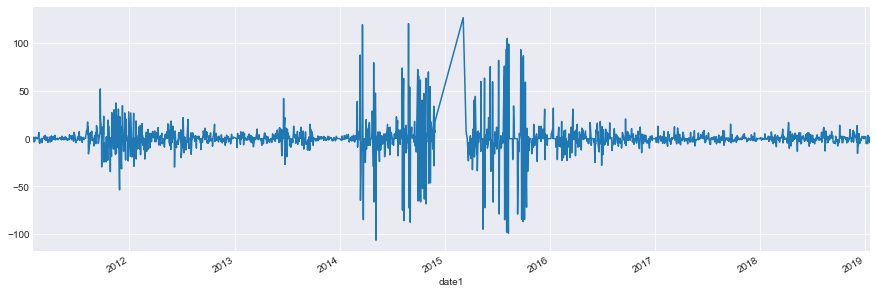

In [77]:
diff = candidate_series.diff()
diff.plot(grid=True)

The result looks stationary

In [78]:
df1.head()

,t,ABSPR,1YLSPR,1T3YSPR,3T5YSPR,BBBABSPR,BBB1T3SPR,BBB3T5SPR,CDS1Y,CDS2Y,CDS3Y,CDS4Y,CDS5Y,CLI SADJ,CPI
date1,,,,,,,,,,,,,,,
2011-02-01,16,513.0,264.0,476.0,569.0,503.0,487.0,537.0,51.25,87.75,114.25,127.5,143.00,103.37,100.78
2011-02-02,17,487.0,241.0,449.0,545.0,479.0,462.0,516.0,51.75,88.75,115.25,128.5,144.67,103.37,100.78
2011-02-03,18,467.0,238.0,426.0,528.0,453.0,433.0,501.0,53.25,92.75,119.25,131.5,147.33,103.37,100.78
2011-02-04,19,485.0,255.0,443.0,548.0,473.0,453.0,521.0,49.75,89.75,116.25,129.5,144.33,103.37,100.78
2011-02-07,20,489.0,248.0,447.0,552.0,478.0,457.0,528.0,47.50,85.00,111.50,125.0,140.83,103.37,100.78


Now I perform the ADF test on each CDS series

In [79]:
column_range_cds = range(8,13)

In [80]:
def adfuller_test_cds(X, p_value):
    series = []
    p_values = []
    for column in column_range_cds:
        result = adfuller(df1.iloc[:, column])
        print(df1.columns.values[column])
        print('ADF Statistic: %f' % result[0])
        series.append(column)
        print('p-value: %f' % result[1])
        p_values.append(result[1])
        if result[1]<=p_value:
            print('Stationary, reject H0')
        else:
            print('Non-stationary, H0 is not rejected')
        print('\n')
    adfuller_df = pd.DataFrame(
            {'Series name': series,
             'P-values': p_values})
    return adfuller_df

In [81]:
adfuller_cds_df = adfuller_test_cds(df1, p_value = p_value_critical)
adfuller_cds_df

CDS1Y
ADF Statistic: -2.249418
p-value: 0.188801
Non-stationary, H0 is not rejected


CDS2Y
ADF Statistic: -2.175302
p-value: 0.215331
Non-stationary, H0 is not rejected


CDS3Y
ADF Statistic: -2.544467
p-value: 0.105026
Non-stationary, H0 is not rejected


CDS4Y
ADF Statistic: -2.116050
p-value: 0.238110
Non-stationary, H0 is not rejected


CDS5Y
ADF Statistic: -2.504283
p-value: 0.114436
Non-stationary, H0 is not rejected




,Series name,P-values
0,8,0.188801
1,9,0.215331
2,10,0.105026
3,11,0.238110
4,12,0.114436


In [82]:
df1_diff = df1.diff(periods=1).dropna()
df1_diff.head()

,t,ABSPR,1YLSPR,1T3YSPR,3T5YSPR,BBBABSPR,BBB1T3SPR,BBB3T5SPR,CDS1Y,CDS2Y,CDS3Y,CDS4Y,CDS5Y,CLI SADJ,CPI
date1,,,,,,,,,,,,,,,
2011-02-02,1.0,-26.0,-23.0,-27.0,-24.0,-24.0,-25.0,-21.0,0.50,1.00,1.00,1.0,1.67,0.0,0.0
2011-02-03,1.0,-20.0,-3.0,-23.0,-17.0,-26.0,-29.0,-15.0,1.50,4.00,4.00,3.0,2.66,0.0,0.0
2011-02-04,1.0,18.0,17.0,17.0,20.0,20.0,20.0,20.0,-3.50,-3.00,-3.00,-2.0,-3.00,0.0,0.0
2011-02-07,1.0,4.0,-7.0,4.0,4.0,5.0,4.0,7.0,-2.25,-4.75,-4.75,-4.5,-3.50,0.0,0.0
2011-02-08,1.0,-4.0,-11.0,2.0,-13.0,-8.0,-6.0,-15.0,0.00,0.50,0.50,0.0,-0.33,0.0,0.0


All CDS time-series are difference stationary

Let us print Granger causality test results for chosen number of lags of supposed variables.

In [83]:
def granger_printer(maxlag=10): 
    #stationary series are needed for the test
    bonds1y = df1['1YLSPR'] #as 1y-bond spreads are stationary, these are included without differencing
    cds1y = df1['CDS1Y'].diff(periods = 1)
    df_1y = pd.DataFrame(
            {'Spreads1Y': bonds1y,
             'CDS1Y': cds1y})
    df_1y = df_1y.dropna()
    
    print('1y bonds on 1y CDS')
    grangercausalitytests(df_1y[['Spreads1Y', 'CDS1Y']], maxlag=maxlag, addconst=True, verbose=True)
    print('\n')
    print('1y CDS on 1y bonds')
    grangercausalitytests(df_1y[['CDS1Y', 'Spreads1Y']], maxlag=maxlag, addconst=True, verbose=True)
    print('\n')
    
    print('3y bonds on 3y CDS')
    grangercausalitytests(df1_diff[['1T3YSPR', 'CDS3Y']], maxlag=maxlag, addconst=True, verbose=True)
    print('\n')
    print('3y CDS on 3y bonds')
    grangercausalitytests(df1_diff[['CDS3Y', '1T3YSPR']], maxlag=maxlag, addconst=True, verbose=True)
    print('\n')
    
    print('5y bonds on 5y CDS')
    grangercausalitytests(df1_diff[['3T5YSPR', 'CDS5Y']], maxlag=maxlag, addconst=True, verbose=True)
    print('\n')
    print('5y CDS on 5y bonds')
    grangercausalitytests(df1_diff[['CDS5Y', '3T5YSPR']], maxlag=maxlag, addconst=True, verbose=True)
    print('\n')
    
    print('3y BBB bonds on 3y CDS')
    grangercausalitytests(df1_diff[['BBB1T3SPR', 'CDS3Y']], maxlag=maxlag, addconst=True, verbose=True)
    print('\n')
    print('3y CDS on 3y BBB bonds')
    grangercausalitytests(df1_diff[['CDS3Y', 'BBB1T3SPR']], maxlag=maxlag, addconst=True, verbose=True)
    print('\n')
    print('5y BBB bonds on 5y CDS')
    grangercausalitytests(df1_diff[['BBB3T5SPR', 'CDS5Y']], maxlag=maxlag, addconst=True, verbose=True)
    print('\n')
    print('5y CDS on 5y BBB bonds')
    grangercausalitytests(df1_diff[['CDS5Y', 'BBB3T5SPR']], maxlag=maxlag, addconst=True, verbose=True)

In [ ]:
granger_printer(maxlag = 10) #H0: series 2 do not Granger-cause series 1

<B>Result:</B>
<br><br>
1-year bond spreads: CDS do not Granger-cause bonds, bonds Granger-cause CDS (lags>=4)<br>
3-year bond spreads: CDS do not Granger-cause bonds, bonds Granger-cause CDS (lags>=3)<br>
5-year bond spreads: CDS do not Granger-cause bonds, bonds Granger-cause CDS (lags>=3)<br>
<br>
3-year BBB bond spreads: CDS do not Granger-cause bonds, bonds Granger-cause CDS (lags>=3)<br>
5-year BBB bond spreads: CDS do not Granger-cause bonds, bonds Granger-cause CDS (lags>=3)

The result indicates that previous CDS spreads will not help in forecasting bond spreads.

## Saving results

In [85]:
conditional_df.to_csv('conditional_df.csv', index=True)
exog_df.to_csv('exog_df.csv', index=True)

# Out-of-sample performance

Now I proceed to the 'test' portion of the data in order to evaluate the performance of fitted models.

In [13]:
conditional_df = read_csv('conditional_df.csv', header=0, index_col=0, squeeze=True)
conditional_df
warnings.filterwarnings("ignore")

In [14]:
exog_df = read_csv('exog_df.csv', header=0, index_col=0, squeeze=True)
exog_df.head()

,CLI,CPI
date1,,
2011-02-01,103.37,100.78
2011-02-02,103.37,100.78
2011-02-03,103.37,100.78
2011-02-04,103.37,100.78
2011-02-07,103.37,100.78


In [15]:
training_set_size = 0.7

In [16]:
p_value_critical = 0.05

## Conditional mean forecasts

Forecast for chosen series:

In [90]:
#List of series: ABSPR, 1YLSPR, 1T3YSPR, 3T5YSPR, BBBABSPR, BBB1T3SPR, BBB3T5SPR
candidate_series = df1['ABSPR'] #set the one you need

In [91]:
df1[int(len(df1) * training_set_size):].describe()

,t,ABSPR,1YLSPR,1T3YSPR,3T5YSPR,BBBABSPR,BBB1T3SPR,BBB3T5SPR,CDS1Y,CDS2Y,CDS3Y,CDS4Y,CDS5Y,CLI SADJ,CPI
count,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000
mean,1728.772414,60.667241,41.162069,62.972414,56.084483,35.531034,14.906897,47.360345,49.056483,69.366483,96.336328,124.472793,152.949672,100.529534,100.303121
std,168.016180,62.536605,63.508622,62.231580,64.130061,61.335602,68.455083,65.099176,29.544114,25.363528,24.652591,25.671739,29.175588,0.334979,0.276133
min,1439.000000,-53.000000,-111.000000,-62.000000,-62.000000,-92.000000,-153.000000,-109.000000,13.210000,35.810000,54.400000,78.050000,101.950000,99.700000,99.460000
25%,1583.750000,10.000000,-4.000000,7.750000,7.000000,-13.250000,-44.250000,5.000000,22.702500,46.780000,77.430000,108.982500,132.465000,100.330000,100.200000
50%,1728.500000,59.000000,31.000000,69.000000,40.000000,28.000000,14.500000,37.000000,35.815000,58.580000,93.915000,123.045000,149.780000,100.500000,100.330000
75%,1873.250000,104.250000,75.250000,114.000000,90.000000,71.250000,68.000000,77.500000,72.207500,94.030000,111.360000,136.372500,167.705000,100.807500,100.430000
max,2022.000000,220.000000,296.000000,190.000000,231.000000,193.000000,164.000000,217.000000,121.450000,132.360000,160.680000,200.470000,238.550000,101.030000,101.000000


In [92]:
def evaluate_1arima_oos(X):
    dataset = X
    training_size = int(len(dataset) * training_set_size)
    train = dataset[0:training_size]
    test = dataset[training_size:]
    

    p = conditional_df.iloc[df1.columns.get_loc(X.name)-1, 1]
    d = conditional_df.iloc[df1.columns.get_loc(X.name)-1, 2]
    q = conditional_df.iloc[df1.columns.get_loc(X.name)-1, 3]
    
    predictions = []
    history = [h for h in train]
    test_plot = [c for c in test]
    
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat.item(0))
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    rmse = sqrt(error)
    print('Test MSE: %.3f' % error)
    print('Test RMSE: %.3f' % rmse)

    plt.plot(test_plot)
    plt.plot(predictions, color='red')
    plt.show()

In [ ]:
evaluate_1arima_oos(candidate_series)

Forecast for all series:

In [94]:
def evaluate_1arimax_oos(X):
    dataset = X
    training_size = int(len(dataset) * training_set_size)
    train = dataset[0:training_size]
    test = dataset[training_size:]
    
    exog_df_tr = exog_df.iloc[ :training_size, ]
    exog_df_te = exog_df.iloc[ training_size: , ] 

    p = conditional_df.iloc[df1.columns.get_loc(X.name)-1, 4]
    d = conditional_df.iloc[df1.columns.get_loc(X.name)-1, 5]
    q = conditional_df.iloc[df1.columns.get_loc(X.name)-1, 6]
    
    
    predictions = []
    history = [h for h in train]
    exogen = exog_df_tr
    list_expected = []
    
    test_plot = [c for c in test]
    
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q), exog = exogen)
        model_fit = model.fit(disp=0)
        exogen = exogen.append(exog_df_te.iloc[t,:])
        output = model_fit.forecast(exog = np.asarray(exog_df_te.iloc[t,:]).reshape(1,2))
        yhat = output[0]
        predictions.append(yhat.item(0))
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    rmse = sqrt(error)
    print('Test MSE: %.3f' % error)
    print('Test RMSE: %.3f' % rmse)
    
    df_expected = pd.DataFrame(
            {'True': test,
             'pred': predictions
            })
    
   
    
    plt.plot(test_plot)
    plt.plot(predictions, color='red')
    plt.show()
    return df_expected

In [95]:
evaluate_1arimax_oos(candidate_series)

In [96]:
def arimas_oos(X):
    
    
    df_results = pd.DataFrame({'Time_step': df1['t'].iloc[int(len(df1['t']) * training_set_size): , ]})
    df_resids_test = pd.DataFrame({'Time_step': df1['t'].iloc[int(len(df1['t']) * training_set_size): , ]})
    rmse_list = []
    col_list = []
    
    for column in range(1,8):
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
    
        p = conditional_df.iloc[column-1, 4]
        d = conditional_df.iloc[column-1, 5]
        q = conditional_df.iloc[column-1, 6]
    
    
        predictions = []
        history = [h for h in train]
        
        
        test_plot = [c for c in test]
        
        resid_test = []
        time_stamp = []
        
        
        for t in range(len(test)):
            model = ARIMA(history, order=(p,d,q))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat.item(0))
            obs = test[t]
            history.append(obs)
            resid_test.append(int((yhat - obs).item(0)))
            time_stamp.append(df1['t'].iloc[int(len(df1['t']) * training_set_size): , ])
            #print(int((yhat - obs).item(0)))
            #print('predicted=%f, expected=%f' % (yhat, obs))
        error = mean_squared_error(test, predictions)
        rmse = sqrt(error)
        rmse_list.append(rmse)
        col_list.append(column)
        print('Test MSE: %.3f' % error)
        print('Test RMSE: %.3f' % rmse)
        plt.plot(test_plot)
        plt.plot(predictions, color='red')
        plt.show()
        
        df_expected_col = pd.DataFrame(
            {'True': test,
             'pred': predictions
            })
        df_results = df_results.join(df_expected_col, how = "outer", rsuffix = "_"+str(column))
        #print(list(test.index.values))
        
        df_resid_col = pd.DataFrame(
            {'date1': test.index.values,
             'resid_test': resid_test
            })
        df_resid_col.set_index('date1', inplace = True)
        print(df_resid_col.head())
        
        df_resids_test = df_resids_test.join(df_resid_col, how = "outer", rsuffix = "_"+str(column))
        print(df_resids_test.head())
        
    df_rmse = pd.DataFrame(
            {'Series': col_list,
             'RMSE': rmse_list
            })
        
        
    return df_results, df_resids_test, df_rmse

In [ ]:
df_oos_expected_arimas, df_oos_resids_arimas, df_rmse_arimas = arimas_oos(df1)

In [98]:
df_rmse_arimas

,Series,RMSE
0,1,17.653195
1,2,33.808386
2,3,19.223530
3,4,16.579688
4,5,18.184652
5,6,20.582692
6,7,19.648988


In [99]:
df_oos_expected_arimas.head()

,Time_step,True,pred,True_2,pred_2,True_3,pred_3,True_4,pred_4,True_5,pred_5,True_6,pred_6,True_7,pred_7
date1,,,,,,,,,,,,,,,
2016-09-28,1439,-20.0,9.489452,56.0,75.957234,-18.0,12.161228,-24.0,3.121149,-46.0,-24.623401,-70.0,-48.245995,-20.0,2.208239
2016-09-29,1440,-42.0,-22.965474,23.0,56.868119,-40.0,-19.753964,-48.0,-27.327013,-68.0,-49.799514,-89.0,-73.275216,-44.0,-23.528396
2016-09-30,1441,-45.0,-35.331605,24.0,30.953341,-42.0,-32.975112,-53.0,-42.776276,-80.0,-63.847793,-109.0,-84.687121,-48.0,-39.263333
2016-10-03,1442,12.0,-39.332123,95.0,30.937368,15.0,-35.986473,4.0,-47.968578,-26.0,-74.845920,-55.0,-103.745827,6.0,-42.566961
2016-10-04,1443,-13.0,15.124528,71.0,85.655814,-10.0,17.776432,-21.0,6.280815,-49.0,-22.165257,-79.0,-50.021359,-17.0,7.281364


In [100]:
df_oos_resids_arimas.head()

,Time_step,resid_test,resid_test_2,resid_test_3,resid_test_4,resid_test_5,resid_test_6,resid_test_7
date1,,,,,,,,
2016-09-28,1439,29,19,30,27,21,21,22
2016-09-29,1440,19,33,20,20,18,15,20
2016-09-30,1441,9,6,9,10,16,24,8
2016-10-03,1442,-51,-64,-50,-51,-48,-48,-48
2016-10-04,1443,28,14,27,27,26,28,24


In [101]:
conditional_df.to_csv('1_conditional_df.csv', index=True)
exog_df.to_csv('1_exog_df.csv', index=True)
df_oos_expected_arimas.to_csv('1_df_oos_expected_arimas.csv', index=True)
df_oos_resids_arimas.to_csv('1_df_oos_resids_arimas.csv', index=True)

df_rmse_arimas.to_csv('1_df_rmse_arimas.csv', index=True)

In [102]:
training_set_size = 0.7

In [103]:
def arimax_oos(X):
    
    col_list = []
    df_results = pd.DataFrame({'Time_step': df1['t'].iloc[int(len(df1['t']) * training_set_size): , ]})
    df_resids_test = pd.DataFrame({'Time_step': df1['t'].iloc[int(len(df1['t']) * training_set_size): , ]})
    rmse_list = []
    
    for column in [1,2,3,4,5,6,7]:
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
    
        exog_df_tr = exog_df.iloc[ :training_size, ]
        exog_df_te = exog_df.iloc[ training_size: , ] 

        p = conditional_df.iloc[column-1, 4]
        d = conditional_df.iloc[column-1, 5]
        q = conditional_df.iloc[column-1, 6]
    
    
        predictions = []
        history = [h for h in train]
        exogen = exog_df_tr
        
        test_plot = [c for c in test]
        
        resid_test = []
        time_stamp = []
        
        
        for t in range(len(test)):
            model = ARIMA(history, order=(p,d,q), exog = exogen)
            model_fit = model.fit(disp=0) #start_params=[np.mean(history), .1, .1, .1])
            exogen = exogen.append(exog_df_te.iloc[t,:])
            output = model_fit.forecast(exog = np.asarray(exog_df_te.iloc[t,:]).reshape(1,2))
            yhat = output[0]
            predictions.append(yhat.item(0))
            obs = test[t]
            history.append(obs)
            resid_test.append(int((yhat - obs).item(0)))
            time_stamp.append(df1['t'].iloc[int(len(df1['t']) * training_set_size): , ])
            #print(int((yhat - obs).item(0)))
            #print('predicted=%f, expected=%f' % (yhat, obs))
        error = mean_squared_error(test, predictions)
        rmse = sqrt(error)
        rmse_list.append(rmse)
        col_list.append(column)
        print('Test MSE: %.3f' % error)
        print('Test RMSE: %.3f' % rmse)
        plt.plot(test_plot)
        plt.plot(predictions, color='red')
        plt.show()
        
        df_expected_col = pd.DataFrame(
            {'True': test,
             'pred': predictions
            })
        df_results = df_results.join(df_expected_col, how = "outer", rsuffix = "_"+str(column))
        #print(list(test.index.values))
        
        df_resid_col = pd.DataFrame(
            {'date1': test.index.values,
             'resid_test': resid_test
            })
        df_resid_col.set_index('date1', inplace = True)
        print(df_resid_col.head())
        
        df_resids_test = df_resids_test.join(df_resid_col, how = "outer", rsuffix = "_"+str(column))
        print(df_resids_test.head())
        
    df_rmse = pd.DataFrame(
            {'Series': col_list,
             'RMSE': rmse_list
            })
        
        
    return df_results, df_resids_test, df_rmse

In [ ]:
df_oos_expected_arimax, df_oos_resids_arimax, df_rmse_arimax = arimax_oos(df1)

In [223]:
exog_df.head()

,CLI,CPI
date1,,
2011-02-01,103.37,100.78
2011-02-02,103.37,100.78
2011-02-03,103.37,100.78
2011-02-04,103.37,100.78
2011-02-07,103.37,100.78


In [224]:
df_oos_expected_arimax.head()

,Time_step,True,pred,True_2,pred_2,True_3,pred_3,True_4,pred_4,True_5,pred_5,True_6,pred_6,True_7,pred_7
date1,,,,,,,,,,,,,,,
2016-09-28,1439,-20.0,11.883564,56.0,79.666617,-18.0,14.695461,-24.0,3.121149,-46.0,-21.654234,-70.0,-48.245995,-20.0,5.389019
2016-09-29,1440,-42.0,-20.501262,23.0,60.705240,-40.0,-17.192287,-48.0,-27.327013,-68.0,-46.477031,-89.0,-73.275216,-44.0,-20.232612
2016-09-30,1441,-45.0,-32.831003,24.0,35.179822,-42.0,-30.627994,-53.0,-42.776276,-80.0,-60.458166,-109.0,-84.687121,-48.0,-35.862675
2016-10-03,1442,12.0,-37.412798,95.0,34.019417,15.0,-34.040722,4.0,-47.968578,-26.0,-72.179902,-55.0,-103.745827,6.0,-39.926814
2016-10-04,1443,-13.0,16.873671,71.0,88.452887,-10.0,19.581968,-21.0,6.280815,-49.0,-19.745615,-79.0,-50.021359,-17.0,9.654698


In [225]:
df_oos_resids_arimax.head()

,Time_step,resid_test,resid_test_2,resid_test_3,resid_test_4,resid_test_5,resid_test_6,resid_test_7
date1,,,,,,,,
2016-09-28,1439,31.883564,23.666617,32.695461,27.121149,24.345766,21.754005,25.389019
2016-09-29,1440,21.498738,37.705240,22.807713,20.672987,21.522969,15.724784,23.767388
2016-09-30,1441,12.168997,11.179822,11.372006,10.223724,19.541834,24.312879,12.137325
2016-10-03,1442,-49.412798,-60.980583,-49.040722,-51.968578,-46.179902,-48.745827,-45.926814
2016-10-04,1443,29.873671,17.452887,29.581968,27.280815,29.254385,28.978641,26.654698


In [226]:
df_rmse_arimax

,Series,RMSE
0,1,17.653195
1,2,33.808386
2,3,19.223530
3,4,16.579688
4,5,18.184652
5,6,20.582692
6,7,19.648988


## Diebold-Mariano test

This function is taken from John Tsang under MIT license (https://github.com/johntwk/Diebold-Mariano-Test)

In [ ]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [186]:
def is_arimax_better_than_arima_oos(X):
    col_list = []
    
    for column in [1,2,3,5,7]:
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
        
        rt = dm_test(test,
             df_oos_expected_arimas.iloc[:,2*column],df_oos_expected_arimax.iloc[:,2*column],
             h = 1, crit="MSE", power=2)
        print(rt)

In [187]:
is_arimax_better_than_arima_oos(df1)

dm_return(DM=0.6570793084408922, p_value=0.5113910170796692)
dm_return(DM=0.1508419867402084, p_value=0.880152900717406)
dm_return(DM=0.133130250391495, p_value=0.8941366273300366)
dm_return(DM=0.6691348565930113, p_value=0.5036761687003806)
dm_return(DM=0.6675651170140731, p_value=0.504677210449145)


The result is that ARIMAX does not perform significantly better out of sample.

## Conditional variance forecasts

Fitted residuals serve as train values

In [30]:
conditional_df = read_csv('conditional_df.csv', header=0, index_col=0, squeeze=True)
conditional_df
warnings.filterwarnings("ignore")

In [87]:
exog_df = read_csv('exog_df.csv', header=0, index_col=0, squeeze=True)
exog_df.head()

,CLI,CPI
date1,,
2011-02-01,103.37,100.78
2011-02-02,103.37,100.78
2011-02-03,103.37,100.78
2011-02-04,103.37,100.78
2011-02-07,103.37,100.78


In [23]:
df_oos_expected_arimas = read_csv('1_df_oos_expected_arimas.csv', header=0, index_col=0, squeeze=True)
df_oos_expected_arimas.head()

,Time_step,True,pred,True_2,pred_2,True_3,pred_3,True_4,pred_4,True_5,pred_5,True_6,pred_6,True_7,pred_7
date1,,,,,,,,,,,,,,,
2016-09-28,1439,-20.0,9.489452,56.0,75.957234,-18.0,12.161228,-24.0,3.121149,-46.0,-24.623401,-70.0,-48.245995,-20.0,2.208239
2016-09-29,1440,-42.0,-22.965474,23.0,56.868119,-40.0,-19.753964,-48.0,-27.327013,-68.0,-49.799514,-89.0,-73.275216,-44.0,-23.528396
2016-09-30,1441,-45.0,-35.331605,24.0,30.953341,-42.0,-32.975112,-53.0,-42.776276,-80.0,-63.847793,-109.0,-84.687121,-48.0,-39.263333
2016-10-03,1442,12.0,-39.332123,95.0,30.937368,15.0,-35.986473,4.0,-47.968578,-26.0,-74.845920,-55.0,-103.745827,6.0,-42.566961
2016-10-04,1443,-13.0,15.124528,71.0,85.655814,-10.0,17.776432,-21.0,6.280815,-49.0,-22.165257,-79.0,-50.021359,-17.0,7.281364


In [34]:
df_oos_resids_arimas = read_csv('1_df_oos_resids_arimas.csv', header=0, index_col=0, squeeze=True)
df_oos_resids_arimas.head()

,Time_step,resid_test,resid_test_2,resid_test_3,resid_test_4,resid_test_5,resid_test_6,resid_test_7
date1,,,,,,,,
2016-09-28,1439,29,19,30,27,21,21,22
2016-09-29,1440,19,33,20,20,18,15,20
2016-09-30,1441,9,6,9,10,16,24,8
2016-10-03,1442,-51,-64,-50,-51,-48,-48,-48
2016-10-04,1443,28,14,27,27,26,28,24


In [219]:
df_oos_expected_arimas.head()

,Time_step,True,pred,True_2,pred_2,True_3,pred_3,True_4,pred_4,True_5,pred_5,True_6,pred_6,True_7,pred_7
date1,,,,,,,,,,,,,,,
2016-09-28,1439,-20.0,9.489452,56.0,75.957234,-18.0,12.161228,-24.0,3.121149,-46.0,-24.623401,-70.0,-48.245995,-20.0,2.208239
2016-09-29,1440,-42.0,-22.965474,23.0,56.868119,-40.0,-19.753964,-48.0,-27.327013,-68.0,-49.799514,-89.0,-73.275216,-44.0,-23.528396
2016-09-30,1441,-45.0,-35.331605,24.0,30.953341,-42.0,-32.975112,-53.0,-42.776276,-80.0,-63.847793,-109.0,-84.687121,-48.0,-39.263333
2016-10-03,1442,12.0,-39.332123,95.0,30.937368,15.0,-35.986473,4.0,-47.968578,-26.0,-74.845920,-55.0,-103.745827,6.0,-42.566961
2016-10-04,1443,-13.0,15.124528,71.0,85.655814,-10.0,17.776432,-21.0,6.280815,-49.0,-22.165257,-79.0,-50.021359,-17.0,7.281364


In [220]:
df_oos_expected_arimax.head()

,Time_step,True,pred,True_2,pred_2,True_3,pred_3,True_4,pred_4,True_5,pred_5,True_6,pred_6,True_7,pred_7
date1,,,,,,,,,,,,,,,
2016-09-28,1439,-20.0,11.883564,56.0,79.666617,-18.0,14.695461,-24.0,3.121149,-46.0,-21.654234,-70.0,-48.245995,-20.0,5.389019
2016-09-29,1440,-42.0,-20.501262,23.0,60.705240,-40.0,-17.192287,-48.0,-27.327013,-68.0,-46.477031,-89.0,-73.275216,-44.0,-20.232612
2016-09-30,1441,-45.0,-32.831003,24.0,35.179822,-42.0,-30.627994,-53.0,-42.776276,-80.0,-60.458166,-109.0,-84.687121,-48.0,-35.862675
2016-10-03,1442,12.0,-37.412798,95.0,34.019417,15.0,-34.040722,4.0,-47.968578,-26.0,-72.179902,-55.0,-103.745827,6.0,-39.926814
2016-10-04,1443,-13.0,16.873671,71.0,88.452887,-10.0,19.581968,-21.0,6.280815,-49.0,-19.745615,-79.0,-50.021359,-17.0,9.654698


In [221]:
df_oos_resids_arimas.head()

,Time_step,resid_test,resid_test_2,resid_test_3,resid_test_4,resid_test_5,resid_test_6,resid_test_7
date1,,,,,,,,
2016-09-28,1439,29,19,30,27,21,21,22
2016-09-29,1440,19,33,20,20,18,15,20
2016-09-30,1441,9,6,9,10,16,24,8
2016-10-03,1442,-51,-64,-50,-51,-48,-48,-48
2016-10-04,1443,28,14,27,27,26,28,24


In [222]:
df_oos_resids_arimax.head()

,Time_step,resid_test,resid_test_2,resid_test_3,resid_test_4,resid_test_5,resid_test_6,resid_test_7
date1,,,,,,,,
2016-09-28,1439,31.883564,23.666617,32.695461,27.121149,24.345766,21.754005,25.389019
2016-09-29,1440,21.498738,37.705240,22.807713,20.672987,21.522969,15.724784,23.767388
2016-09-30,1441,12.168997,11.179822,11.372006,10.223724,19.541834,24.312879,12.137325
2016-10-03,1442,-49.412798,-60.980583,-49.040722,-51.968578,-46.179902,-48.745827,-45.926814
2016-10-04,1443,29.873671,17.452887,29.581968,27.280815,29.254385,28.978641,26.654698


In [31]:
conditional_df

,Series name,p_ar,d_ar,q_ar,p_arx,d_arx,q_arx,p_gar,q_gar,p_garx,q_garx
0,ABSPR,2,1,2,2,1,2,1,1,1,1
1,1YLSPR,1,1,1,1,1,1,0,0,0,0
2,1T3YSPR,1,1,2,2,1,2,1,1,1,1
3,3T5YSPR,1,1,2,2,1,2,1,1,1,1
4,BBBABSPR,1,1,2,2,1,2,1,1,1,1
5,BBB1T3SPR,1,1,2,2,1,2,1,1,1,2
6,BBB3T5SPR,1,1,2,2,1,2,1,1,1,1


In [248]:
def garch_arimas_oos(X):
    
    col_list = []
    df_results = pd.DataFrame({'Time step': df1['t'].iloc[int(len(df1['t']) * training_set_size): , ]})
    rmse_list = []
    
    for column in [1,2,3,4,5,6,7]:
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
        

        p = conditional_df.iloc[column-1, 4]
        d = conditional_df.iloc[column-1, 5]
        q = conditional_df.iloc[column-1, 6]
        
        model = ARIMA(train, order=(p,d,q))
        model_fit = model.fit(disp=0)
        residuals_train = model_fit.resid
        
        p_garch = conditional_df.iloc[column-1, 7]
        q_garch = conditional_df.iloc[column-1, 8]
    
        predictions = []
        history_resid = [h for h in residuals_train]
        
        test_vol = []
        
        if p_garch == 0:
            df_expected_col = pd.DataFrame(
            {'True_vol': [0]*len(test.index.values),
             'date1': test.index.values,
             'pred_vol': [0]*len(test.index.values)
            })
            df_expected_col.set_index('date1', inplace = True)
        else:
        
            for t in range(len(test)):
                model = arch_model(history_resid, p=p_garch, q=q_garch, mean='Zero')
                model_fit_garch = model.fit(disp=0)
                output_garch = model_fit_garch.forecast()
            
                resid_time_t = df_oos_resids_arimas.iloc[t,column]
                history_resid.append(resid_time_t)
                yhat = output_garch.variance.values[-1]
                print(yhat.item(0))
                predictions.append(yhat.item(0))
            
                test_vol.append(np.var(history_resid))
            
                print('predicted=%f, expected=%f' % (yhat, np.var(history_resid)))
            error = mean_squared_error(test_vol, predictions)
            rmse = sqrt(error)
            rmse_list.append(rmse)
            col_list.append(column)
            print('Test MSE: %.3f' % error)
            print('Test RMSE: %.3f' % rmse)
            plt.plot(test_vol)
            plt.plot(predictions, color='red')
            plt.show()
        
        
            df_expected_col = pd.DataFrame(
                {'True_vol': test_vol,
                 'date1': test.index.values,
                 'pred_vol': predictions
                })
            df_expected_col.set_index('date1', inplace = True)
        
        df_results = df_results.join(df_expected_col, how = "outer", rsuffix = "_"+str(column))
        
        
        df_rmse = pd.DataFrame(
            {'Series': col_list,
             'RMSE': rmse_list
            })
        print(df_results.head())
        
        
    return df_results , df_rmse

In [ ]:
df_oos_expected_arimas_garch, df_rmse_arimas_garch = garch_arimas_oos(df1)

In [37]:
df_oos_expected_arimas_garch.head()

,Time step,True_vol,pred_vol,True_vol_2,pred_vol_2,True_vol_3,pred_vol_3,True_vol_4,pred_vol_4,True_vol_5,pred_vol_5,True_vol_6,pred_vol_6,True_vol_7,pred_vol_7
date1,,,,,,,,,,,,,,,
2016-09-28,1439,761.723405,557.785425,0,0,801.409794,445.224502,866.468823,772.059114,774.872347,446.914085,797.522119,526.385053,843.649904,443.254034
2016-09-29,1440,761.427886,658.380432,0,0,801.113754,472.217851,866.124275,772.421288,774.539899,450.484152,797.099864,526.368262,843.322369,448.331458
2016-09-30,1441,760.925793,621.152052,0,0,800.582352,473.622173,865.558688,764.446605,774.157399,448.650850,796.937111,517.114576,842.747151,449.982508
2016-10-03,1442,762.281227,535.714959,0,0,801.834233,459.673880,866.838300,749.205042,775.284208,443.903493,798.047049,523.330910,843.824162,438.782186
2016-10-04,1443,762.298435,1022.699973,0,0,801.781641,563.625075,866.737188,797.628863,775.212109,531.431994,798.037856,603.960580,843.627414,513.685387


In [38]:
df_rmse_arimas_garch

,Series,RMSE
0,1,354.830298
1,3,422.414669
2,4,385.828515
3,5,333.477933
4,6,286.654133
5,7,363.535865


In [216]:
def garch_arimax_oos(X):
    
    col_list = []
    df_results = pd.DataFrame({'Time step': df1['t'].iloc[int(len(df1['t']) * training_set_size): , ]})
    rmse_list = []
    
    for column in [1,2,3,4,5,6,7]:
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
        
        exog_df_tr = exog_df.iloc[ :training_size, ]
        exog_df_te = exog_df.iloc[ training_size: , ] 

        p = conditional_df.iloc[column-1, 4]
        d = conditional_df.iloc[column-1, 5]
        q = conditional_df.iloc[column-1, 6]
        
        model = ARIMA(train, order=(p,d,q), exog = exog_df_tr)
        model_fit = model.fit(disp=0)
        residuals_train = model_fit.resid
        
        p_garch = conditional_df.iloc[column-1, 9]
        q_garch = conditional_df.iloc[column-1, 10]
    
        predictions = []
        history_resid = [h for h in residuals_train]
        
        test_vol = []
        
        if p_garch == 0:
            df_expected_col = pd.DataFrame(
            {'True_vol': [0]*len(test.index.values),
             'date1': test.index.values,
             'pred_vol': [0]*len(test.index.values)
            })
            df_expected_col.set_index('date1', inplace = True)
        else:
        
            for t in range(len(test)):
                model = arch_model(history_resid, p=p_garch, q=q_garch, mean='Zero')
                model_fit_garch = model.fit(disp=0)
                output_garch = model_fit_garch.forecast()
            
                resid_time_t = df_oos_resids_arimax.iloc[t,column]
                history_resid.append(resid_time_t)
                yhat = output_garch.variance.values[-1]
                print(yhat.item(0))
                predictions.append(yhat.item(0))
            
                test_vol.append(resid_time_t**2)
            
                print('predicted=%f, expected=%f' % (yhat, resid_time_t**2))
            error = mean_squared_error(test_vol, predictions)
            rmse = sqrt(error)
            rmse_list.append(rmse)
            col_list.append(column)
            print('Test MSE: %.3f' % error)
            print('Test RMSE: %.3f' % rmse)
            plt.plot(test_vol)
            plt.plot(predictions, color='red')
            plt.show()
        
        
            df_expected_col = pd.DataFrame(
                {'True_vol': test_vol,
                 'date1': test.index.values,
                 'pred_vol': predictions
                })
            df_expected_col.set_index('date1', inplace = True)
        
        df_results = df_results.join(df_expected_col, how = "outer", rsuffix = "_"+str(column))
        
        df_rmse = pd.DataFrame(
            {'Series': col_list,
             'RMSE': rmse_list
            })
        print(df_results.head())
        
        
    return df_results, df_rmse
    

In [ ]:
df_oos_expected_arimax_garch, df_rmse_arimax_garch = garch_arimax_oos(df1)

In [218]:
df_oos_expected_arimax_garch.head()

,Time step,True_vol,pred_vol,True_vol_2,pred_vol_2,True_vol_3,pred_vol_3,True_vol_4,pred_vol_4,True_vol_5,pred_vol_5,True_vol_6,pred_vol_6,True_vol_7,pred_vol_7
date1,,,,,,,,,,,,,,,
2016-09-28,1439,1016.561643,542.736462,0,0,1068.993195,442.835801,735.556715,739.536948,592.716321,435.202017,473.236739,509.861955,644.602305,424.498282
2016-09-29,1440,462.195746,690.374025,0,0,520.191794,477.374784,427.372396,741.127879,463.238192,445.776714,247.268819,523.800146,564.888731,436.430009
2016-09-30,1441,148.084482,663.782337,0,0,129.322530,484.201340,104.524526,734.937127,381.883259,450.282082,591.116072,499.270605,147.314653,444.837148
2016-10-03,1442,2441.624562,576.470645,0,0,2404.992386,472.318639,2700.733089,720.882765,2132.583349,451.065575,2376.155681,530.786796,2109.272274,437.131496
2016-10-04,1443,892.436235,1028.830862,0,0,875.092838,568.947169,744.242869,772.452672,855.819043,527.745916,839.761626,643.929242,710.472911,504.048077


# Saving results

In [207]:
conditional_df

,Series name,p_ar,d_ar,q_ar,p_arx,d_arx,q_arx,p_gar,q_gar,p_garx,q_garx
0,ABSPR,2,1,2,2,1,2,1,1,1,1
1,1YLSPR,1,1,1,1,1,1,0,0,0,0
2,1T3YSPR,1,1,2,2,1,2,1,1,1,1
3,3T5YSPR,1,1,2,2,1,2,1,1,1,1
4,BBBABSPR,1,1,2,2,1,2,1,1,1,1
5,BBB1T3SPR,1,1,2,2,1,2,1,1,1,2
6,BBB3T5SPR,1,1,2,2,1,2,1,1,1,1


In [212]:
df_rmse_arimas

,Series,RMSE
0,1,17.653195
1,2,33.808386
2,3,19.223530
3,4,16.579688
4,5,18.184652
5,6,20.582692
6,7,19.648988


In [250]:
df_rmse_arimax

,Series,RMSE
0,1.0,17.600081
1,2.0,33.792517
2,3.0,19.213188
3,4.0,16.579688
4,5.0,18.116228
5,6.0,20.582692
6,7.0,19.551812


In [251]:
df_rmse_arimas_garch

,Series,RMSE
0,1,354.830298
1,3,422.414669
2,4,385.828515
3,5,333.477933
4,6,286.654133
5,7,363.535865


In [252]:
df_rmse_arimax_garch

,Series,RMSE
0,1,799.774688
1,3,1277.136611
2,4,557.911300
3,5,703.434057
4,6,929.075028
5,7,1449.411914


In [253]:
conditional_df.to_csv('1_conditional_df.csv', index=True)
exog_df.to_csv('1_exog_df.csv', index=True)
df_oos_expected_arimas.to_csv('1_df_oos_expected_arimas.csv', index=True)
df_oos_resids_arimas.to_csv('1_df_oos_resids_arimas.csv', index=True)
df_oos_expected_arimax.to_csv('1_df_oos_expected_arimax.csv', index=True)
df_oos_resids_arimax.to_csv('1_df_oos_resids_arimax.csv', index=True)
df_rmse_arimas.to_csv('1_df_rmse_arimas.csv', index=True)
df_rmse_arimax.to_csv('1_df_rmse_arimax.csv', index=True)
df_rmse_arimas_garch.to_csv('1_df_rmse_arimas_garch.csv', index=True)
df_rmse_arimax_garch.to_csv('1_df_rmse_arimax_garch.csv', index=True)

# Weak-form efficiency formal test

## Variance Ratio test

In [122]:
from arch.unitroot import VarianceRatio
def variance_ratio(X):
    for column in range(1,8):
        dataset = X.iloc[:,column]
        vr = VarianceRatio(dataset.diff().dropna(), 12)
        print(column)
        print(vr.summary().as_text())

In [123]:
variance_ratio(df1)

1
     Variance-Ratio Test Results     
Test Statistic                -15.757
P-value                         0.000
Lags                               12
-------------------------------------

Computed with overlapping blocks (de-biased)
2
     Variance-Ratio Test Results     
Test Statistic                -14.502
P-value                         0.000
Lags                               12
-------------------------------------

Computed with overlapping blocks (de-biased)
3
     Variance-Ratio Test Results     
Test Statistic                -15.957
P-value                         0.000
Lags                               12
-------------------------------------

Computed with overlapping blocks (de-biased)
4
     Variance-Ratio Test Results     
Test Statistic                -15.613
P-value                         0.000
Lags                               12
-------------------------------------

Computed with overlapping blocks (de-biased)
5
     Variance-Ratio Test Results     
Test Sta

It seems that hypothesis that spread fluctuations are random walk is rejected at any significance level.

# Prediction-comparative tests

## Static ARIMA DM-test

Static ARIMA

In [30]:
def predict_by_coef(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat

def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)

def arimas_static_oos(X):
    
    
    df_results = pd.DataFrame({'Time_step': df1['t'].iloc[int(len(df1['t']) * training_set_size): , ]})
    df_resids_test = pd.DataFrame({'Time_step': df1['t'].iloc[int(len(df1['t']) * training_set_size): , ]})
    rmse_list = []
    col_list = []
    
    for column in range(1,8):
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
    
        p = conditional_df.iloc[column-1, 4]
        d = conditional_df.iloc[column-1, 5]
        q = conditional_df.iloc[column-1, 6]
    
    
        predictions = []
        history = [h for h in train]
        
        
        test_plot = [c for c in test]
        
        resid_test = []
        time_stamp = []
        
        
        for t in range(len(test)):
            model = ARIMA(train, order=(p,d,q))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            
            ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
            #print(ar_coef)
            #print(ma_coef)
            
            diff = difference(history)
            yhat = history[-1] + predict_by_coef(ar_coef, diff) + predict_by_coef(ma_coef, resid)
            
            predictions.append(yhat.item(0))
            obs = test[t]
            history.append(obs)
            resid_test.append(int((yhat - obs).item(0)))
            time_stamp.append(df1['t'].iloc[int(len(df1['t']) * training_set_size): , ])
            #print(int((yhat - obs).item(0)))
            #print('predicted=%f, expected=%f' % (yhat, obs))
        error = mean_squared_error(test, predictions)
        rmse = sqrt(error)
        rmse_list.append(rmse)
        col_list.append(column)
        print('Test MSE: %.3f' % error)
        print('Test RMSE: %.3f' % rmse)
        plt.plot(test_plot)
        plt.plot(predictions, color='red')
        plt.show()
        
        df_expected_col = pd.DataFrame(
            {'True': test,
             'pred': predictions
            })
        df_results = df_results.join(df_expected_col, how = "outer", rsuffix = "_"+str(column))
        #print(list(test.index.values))
        
        df_resid_col = pd.DataFrame(
            {'date1': test.index.values,
             'resid_test': resid_test
            })
        df_resid_col.set_index('date1', inplace = True)
        print(df_resid_col.head())
        
        df_resids_test = df_resids_test.join(df_resid_col, how = "outer", rsuffix = "_"+str(column))
        print(df_resids_test.head())
        
    df_rmse = pd.DataFrame(
            {'Series': col_list,
             'RMSE': rmse_list
            })
        
        
    return df_results, df_resids_test, df_rmse

In [ ]:
df_oos_expected_static_arimas, df_oos_resids_static_arimas, df_rmse_static_arimas = arimas_static_oos(df1)

In [32]:
df_rmse_static_arimas

,Series,RMSE
0,1,20.935580
1,2,49.958829
2,3,22.821581
3,4,19.523146
4,5,21.722880
5,6,25.167270
6,7,22.985861


In [43]:
df_oos_expected_static_arimas.to_csv('1_df_oos_expected_static_arimas.csv', index=True)
df_oos_resids_static_arimas.to_csv('1_df_oos_resids_static_arimas.csv', index=True)
df_rmse_static_arimas.to_csv('1_df_rmse_static_arimas.csv', index=True)

In [298]:
def is_arimas_better_than_static_arimas_oos(X):
    col_list = []
    
    for column in range(1,8):
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
        rt = dm_test(test,
            df_oos_expected_static_arimas.iloc[:,2*column], df_oos_expected_arimas.iloc[:,2*column],
            h = 1, crit="MSE", power=4)
        print(rt)

In [299]:
is_arimas_better_than_static_arimas_oos(df1)

dm_return(DM=5.389823049591617, p_value=1.0279878232175916e-07)
dm_return(DM=5.070013335921913, p_value=5.361610706652992e-07)
dm_return(DM=5.24727062768167, p_value=2.1692631622554185e-07)
dm_return(DM=5.713879761409207, p_value=1.7681338379902138e-08)
dm_return(DM=5.537431747403959, p_value=4.660505383363402e-08)
dm_return(DM=6.053090014454625, p_value=2.5547295622295918e-09)
dm_return(DM=4.735398446451162, p_value=2.752574308121129e-06)


In [297]:
df_oos_expected_st_lstm = read_csv('1_df_oos_expected_st_lstm.csv', header=0, index_col=0, squeeze=True)
df_oos_expected_st_lstm.tail()

,Time_step,True,pred,True_2,pred_2,True_3,pred_3,True_4,pred_4,True_5,pred_5,True_6,pred_6,True_7,pred_7
date1,,,,,,,,,,,,,,,
2019-01-14,2018,126.0,126.699638,-6.0,28.265209,99.0,109.654472,135.0,134.209290,109.0,108.544388,69.0,66.017799,125.0,119.666031
2019-01-15,2019,127.0,127.643463,11.0,-2.398652,100.0,103.473358,137.0,137.747971,109.0,111.955353,69.0,61.187454,125.0,127.703857
2019-01-16,2020,122.0,128.586288,14.0,11.570272,99.0,104.503899,130.0,139.505493,103.0,111.955353,66.0,61.187454,117.0,127.703857
2019-01-17,2021,120.0,123.862167,-9.0,14.586103,98.0,103.473358,129.0,133.294937,101.0,104.919708,62.0,57.650993,116.0,119.666031
2019-01-18,2022,117.0,121.965515,-4.0,-4.065976,88.0,102.442696,132.0,132.372681,98.0,102.270805,52.0,53.063324,120.0,118.593376


In [90]:
def is_static_lstm_better_than_static_arimas_oos(X):
    col_list = []
    
    for column in range(1,8):
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
        rt = dm_test(test,
            df_oos_expected_static_arimas.iloc[:,2*column], df_oos_expected_st_lstm.iloc[:,2*column],
            h = 1, crit="MSE", power=4)
        print(rt)

In [91]:
is_static_lstm_better_than_static_arimas_oos(df1)

dm_return(DM=6.528906861881584, p_value=1.4499058511452634e-10)
dm_return(DM=5.255994709421261, p_value=2.0733633658787885e-07)
dm_return(DM=5.812112964291352, p_value=1.0194834116682835e-08)
dm_return(DM=6.053124900029501, p_value=2.5542091124004128e-09)
dm_return(DM=5.3771661718790265, p_value=1.0992114899123741e-07)
dm_return(DM=5.646147940356322, p_value=2.5727826874078287e-08)
dm_return(DM=4.753385065484589, p_value=2.52697788748756e-06)


It seems that both rolling ARIMAs and static LSTM both perform better out of sample than static ARIMAs.

## Rolling ARIMA vs Rolling ARIMAX

In [303]:
def is_arimax_better_than_arimas_oos(X):
    col_list = []
    
    for column in [1,2,3,5,7]:
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
        rt = dm_test(test,
            df_oos_expected_arimas.iloc[:,2*column], df_oos_expected_arimax.iloc[:,2*column],
            h = 1, crit="MSE", power=4)
        print(rt)

In [304]:
is_arimax_better_than_arimas_oos(df1)

dm_return(DM=0.6570793084408922, p_value=0.5113910170796692)
dm_return(DM=0.1508419867402084, p_value=0.880152900717406)
dm_return(DM=0.133130250391495, p_value=0.8941366273300366)
dm_return(DM=0.6691348565930113, p_value=0.5036761687003806)
dm_return(DM=0.6675651170140731, p_value=0.504677210449145)


The results show that ARIMAX does not perform better out of sample, than ARIMA, despite CPI's coefficient being significant

## Rolling ARIMA vs Static LSTM

In [306]:
def is_static_lstm_better_than_arimas_oos(X):
    col_list = []
    
    for column in range(1,8):
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
        rt = dm_test(test,
            df_oos_expected_arimas.iloc[:,2*column], df_oos_expected_st_lstm.iloc[:,2*column],
            h = 1, crit="MSE", power=4)
        print(rt)

In [307]:
is_static_lstm_better_than_arimas_oos(df1)

dm_return(DM=-1.510571758134459, p_value=0.1314431268780475)
dm_return(DM=-2.5339774072256738, p_value=0.011540099256374824)
dm_return(DM=-2.5855548514785838, p_value=0.00996544175449078)
dm_return(DM=-1.480382075881329, p_value=0.13931522756956163)
dm_return(DM=-2.430469046549434, p_value=0.015381986295886932)
dm_return(DM=-2.7963302612205365, p_value=0.005340309113239823)
dm_return(DM=-1.7451597448471816, p_value=0.08148757106728458)


Although static LSTM has outperformed static ARIMA on all 7 sample time series, it is shown, that rolling ARIMA performs better out of sample for 4 out of 7 time series: bonds with <1-year duration, bonds with 3-5 year duration, BBB bonds with 1 to 3 and 3 to 5 year duration.

## Rolling LSTM vs Static LSTM

In [296]:
df_oos_expected_rolling_lstm = read_csv('1_df_oos_expected_rolling_lstm.csv', header=0, index_col=0, squeeze=True)
df_oos_expected_rolling_lstm.tail()

,Time_step,True,pred,True_2,pred_2,True_3,pred_3,True_4,pred_4,True_5,pred_5,True_6,pred_6,True_7,pred_7
date1,,,,,,,,,,,,,,,
2019-01-14,2018,126.0,126.468987,-6.0,31.297626,99.0,103.641457,135.0,130.841843,109.0,101.253220,69.0,73.661148,125.0,117.638535
2019-01-15,2019,127.0,127.543633,11.0,-2.303172,100.0,97.787659,137.0,134.651230,109.0,105.272789,69.0,70.822556,125.0,124.988197
2019-01-16,2020,122.0,128.594635,14.0,20.998566,99.0,98.808098,130.0,136.589767,103.0,105.178734,66.0,70.767799,117.0,124.892319
2019-01-17,2021,120.0,123.390572,-9.0,23.925222,98.0,97.768982,129.0,129.899673,101.0,97.497185,62.0,68.588531,116.0,117.671715
2019-01-18,2022,117.0,121.288429,-4.0,-23.811474,88.0,96.766563,132.0,128.946213,98.0,94.900223,52.0,65.678009,120.0,116.468483


In [320]:
def is_rolling_lstm_better_than_static_lstm_oos(X):
    col_list = []
    
    for column in range(1,8):
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
        rt = dm_test(test,
            df_oos_expected_st_lstm.iloc[:,2*column], df_oos_expected_rolling_lstm.iloc[:,2*column],
            h = 1, crit="MSE", power=4)
        print(rt)

In [321]:
is_rolling_lstm_better_than_static_lstm_oos(df1)

dm_return(DM=-2.5709557693870906, p_value=0.010390432249601327)
dm_return(DM=-2.1650702101362578, p_value=0.030790080035612056)
dm_return(DM=0.7055619264756272, p_value=0.4807443694018132)
dm_return(DM=-2.7557714749894244, p_value=0.006039771691008447)
dm_return(DM=-3.0032239325177392, p_value=0.0027867057847744516)
dm_return(DM=-2.137332720828037, p_value=0.03298920685029071)
dm_return(DM=-3.1777434053118907, p_value=0.0015633827719344676)


Rolling LSTM seems to be worse out-of-sample than static LSTM for 6 out of 7 series, non-significantly different for 1 series.

## Rolling LSTM vs Rolling ARIMA

In [318]:
def is_rolling_lstm_better_than_arimas_oos(X):
    col_list = []
    
    for column in range(1,8):
        dataset = X.iloc[:,column]
        training_size = int(len(dataset) * training_set_size)
        train = dataset[0:training_size]
        test = dataset[training_size:]
        rt = dm_test(test,
            df_oos_expected_arimas.iloc[:,2*column], df_oos_expected_rolling_lstm.iloc[:,2*column],
            h = 1, crit="MSE", power=4)
        print(rt)

In [319]:
is_rolling_lstm_better_than_arimas_oos(df1)

dm_return(DM=-2.52196389410842, p_value=0.01193724175568639)
dm_return(DM=-3.4214608575961654, p_value=0.0006667796605800597)
dm_return(DM=-2.271397648056173, p_value=0.02348910055623644)
dm_return(DM=-3.267142406196407, p_value=0.0011506815973633192)
dm_return(DM=-3.5691705136598864, p_value=0.0003878153753561492)
dm_return(DM=-3.769016097179401, p_value=0.00018069098513963396)
dm_return(DM=-3.8955603279153768, p_value=0.00010940643137500683)


Rolling ARIMA seems to be performing better than rolling LSTM for all the time series in study

# Comparison outcome

Although static LSTM performs better than static ARIMA on these samples, in rolling setting ARIMA outperforms this architecture of neural network. <br><br>
I suppose, this may happen due to non-linear properties of these time-series, which are captured in static setting only by non-linear models, such as neural network, but in rolling setting are also approximated by ARIMA, whereas LSTM-network tends to overparametrize.

Thank you for reading this code. 